# Act 3: Generate from Data

In this notebook, you'll generate new data from existing data. We'll be using AI models to get creative:

🎭 Generate AI prompts based on multimodal inputs (text and images)  
🎬 Create static images from scenes we pull from videos  
🤹🏽 Animate images with text prompts  
🍿 Create videos from image and text prompts

In a typical workflow, this means: loading video files, extracting frames with OpenCV or ffmpeg, encoding images to base64, constructing API requests, managing authentication, parsing JSON responses, handling rate limits and errors, writing batch processing loops, saving outputs to disk, and tracking which items have been processed.

In Pixeltable, we can express this workflow without any explicit data handling. It is still the same work, same conceptual flow, but you don't have to craft the data operations. Instead, you can focus on the logic and Pixeltable handles the rest. 

Because Pixeltable handles all that for us, you might notice we're not covering topics like:
- Request batching
- Response parsing
- Retry strategies
- File serialization
- Media encoding/decoding
- Binary data handling
- State persistence
- Concurrency management

## In this notebook

The techniques you'll learn apply to any workflow that chains transformations and applies them across data. We'll use Pixeltable to:

1. **Extract Frames** - Pull a frame from each video scene
2. **Generate Creative Prompts** - Use multimodal AI to create trailer descriptions from frames and transcripts
3. **Create Visual Content** - Generate images and videos from AI prompts
4. **Apply Across All Scenes** - Run the workflow on your entire scene library automatically

**Prerequisites:** You'll need a Gemini API key from [aistudio.google.com](https://aistudio.google.com/apikey). See [Pixeltable's API key configuration guide](https://docs.pixeltable.com/howto/cookbooks/core/workflow-api-keys) for setup instructions.

**Models and Pixeltable UDFs used in this notebook:**

| Google Model | Pixeltable UDF | Purpose |
|--------------|----------------|----------|
| `gemini-2.0-flash` | `pxtf.gemini.generate_content()` | Generate text descriptions from images |
| `imagen-4.0-generate-001` | `pxtf.gemini.generate_images()` | Generate images from text prompts |
| `veo-3.1-generate-preview` | `pxtf.gemini.generate_videos()` | Generate videos from images and text |

In [1]:
import pixeltable as pxt
import pixeltable.functions as pxtf

As we've been doing, we'll take a look at the tables we can "get":

In [2]:
pxt.list_tables()

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/alison-pxt/.pixeltable/pgdata


['scene_view',
 'video-frame-view',
 'primetime_vids',
 'sentences',
 'bug_test/users',
 'bug_test/backup',
 'bug_test/active_users',
 'bug_test/products',
 'bug_test/orders',
 'project/math',
 'project/users',
 'project/products',
 'project/backup',
 'project/active_users']

We'll be working with our `scene_view` table. 

In [3]:
scene_view = pxt.get_table('scene_view')

You can uncomment the code below if you have already gone through this notebook and want to start fresh with the state of `scene_view` before adding any generative AI model inputs or outputs.

In [ ]:
#scene_view.drop_column(scene_view.beginning_frame)
#scene_view.drop_column(scene_view.prompt_response)
#scene_view.drop_column(scene_view.prompt_text)

We can also check out the history of our table, to revisit where we've been!

In [5]:
# Your may look different than mine
scene_view.history()

,version,created_at,user,change_type,inserts,updates,deletes,errors,schema_change
0,58,2026-01-28 01:24:45.781893+00:00,None,schema,0,18,0,0,Deleted: prompt_response
1,57,2026-01-28 01:24:45.765760+00:00,None,schema,0,18,0,0,Deleted: beginning_frame
2,56,2026-01-28 01:15:26.764429+00:00,None,schema,0,18,0,0,Added: prompt_response
3,55,2026-01-28 01:14:50.262378+00:00,None,schema,0,18,0,0,Added: prompt_text
4,54,2026-01-28 00:47:43.944889+00:00,None,schema,0,18,0,0,Added: beginning_frame
5,53,2026-01-28 00:19:26.732241+00:00,None,schema,0,18,0,0,Deleted: prompt_text
6,52,2026-01-28 00:19:12.906929+00:00,None,schema,0,18,0,0,Deleted: beginning_frame
7,51,2026-01-28 00:14:25.031152+00:00,None,schema,0,18,0,0,Added: prompt_text
8,50,2026-01-28 00:08:24.298761+00:00,None,schema,0,18,0,0,Added: beginning_frame
9,49,2026-01-28 00:08:24.290867+00:00,None,schema,0,18,0,0,Deleted: beginning_frame


In addition to viewing table history, you can do time travel, rollback to a previous version, and revert changes. See this page in our docs for more: https://docs.pixeltable.com/platform/version-control

As a reminder, here is our view schema:

In [8]:
scene_view

view 'scene_view' (of 'primetime_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              audio  Required[Audio]                       extract_audio(video_segment)
      transcription   Required[Json]                    transcribe(audio, model='base')
    transcript_text           String                  transcription.text.astype(String)
    transcript_lang           String              transcription.language.astype(String)
              video            Video                                                   
              title           String                                                   
          promo_img            Image                                                   
         promo_text           String                                                   
           duration            Float                                get_duration(video)
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

## 01 - Extract Frames

You already have `scene_view` from Act 2 with video segments for each scene. Now you'll add a computed column to extract a frame from each segment.

As a reminder, `scene_view` is a view built on top of `primetime_vids`, which means it automatically has access to all the parent table's columns (like `title` and `promo_text`).

Computed columns work on views the same way they work on tables - they're automatically applied to every row:

- `extract_frame()` is a Pixeltable UDF that pulls a single frame at a specific timestamp from each video segment - we used this UDF already in Act 1
- Output frames are stored persistently
- If you add a new row to `primetime_vids`, only those new scenes are processed (incremental updates)

In [9]:
scene_view.add_computed_column(
    beginning_frame=scene_view.video_segment.extract_frame(timestamp=5),
    if_exists='replace'
)

Added 18 column values with 0 errors in 1.54 s (11.65 rows/s)


18 rows updated.

Let's look at the frames we just extracted:

pos,video_segment,beginning_frame
5,,
6,,
7,,

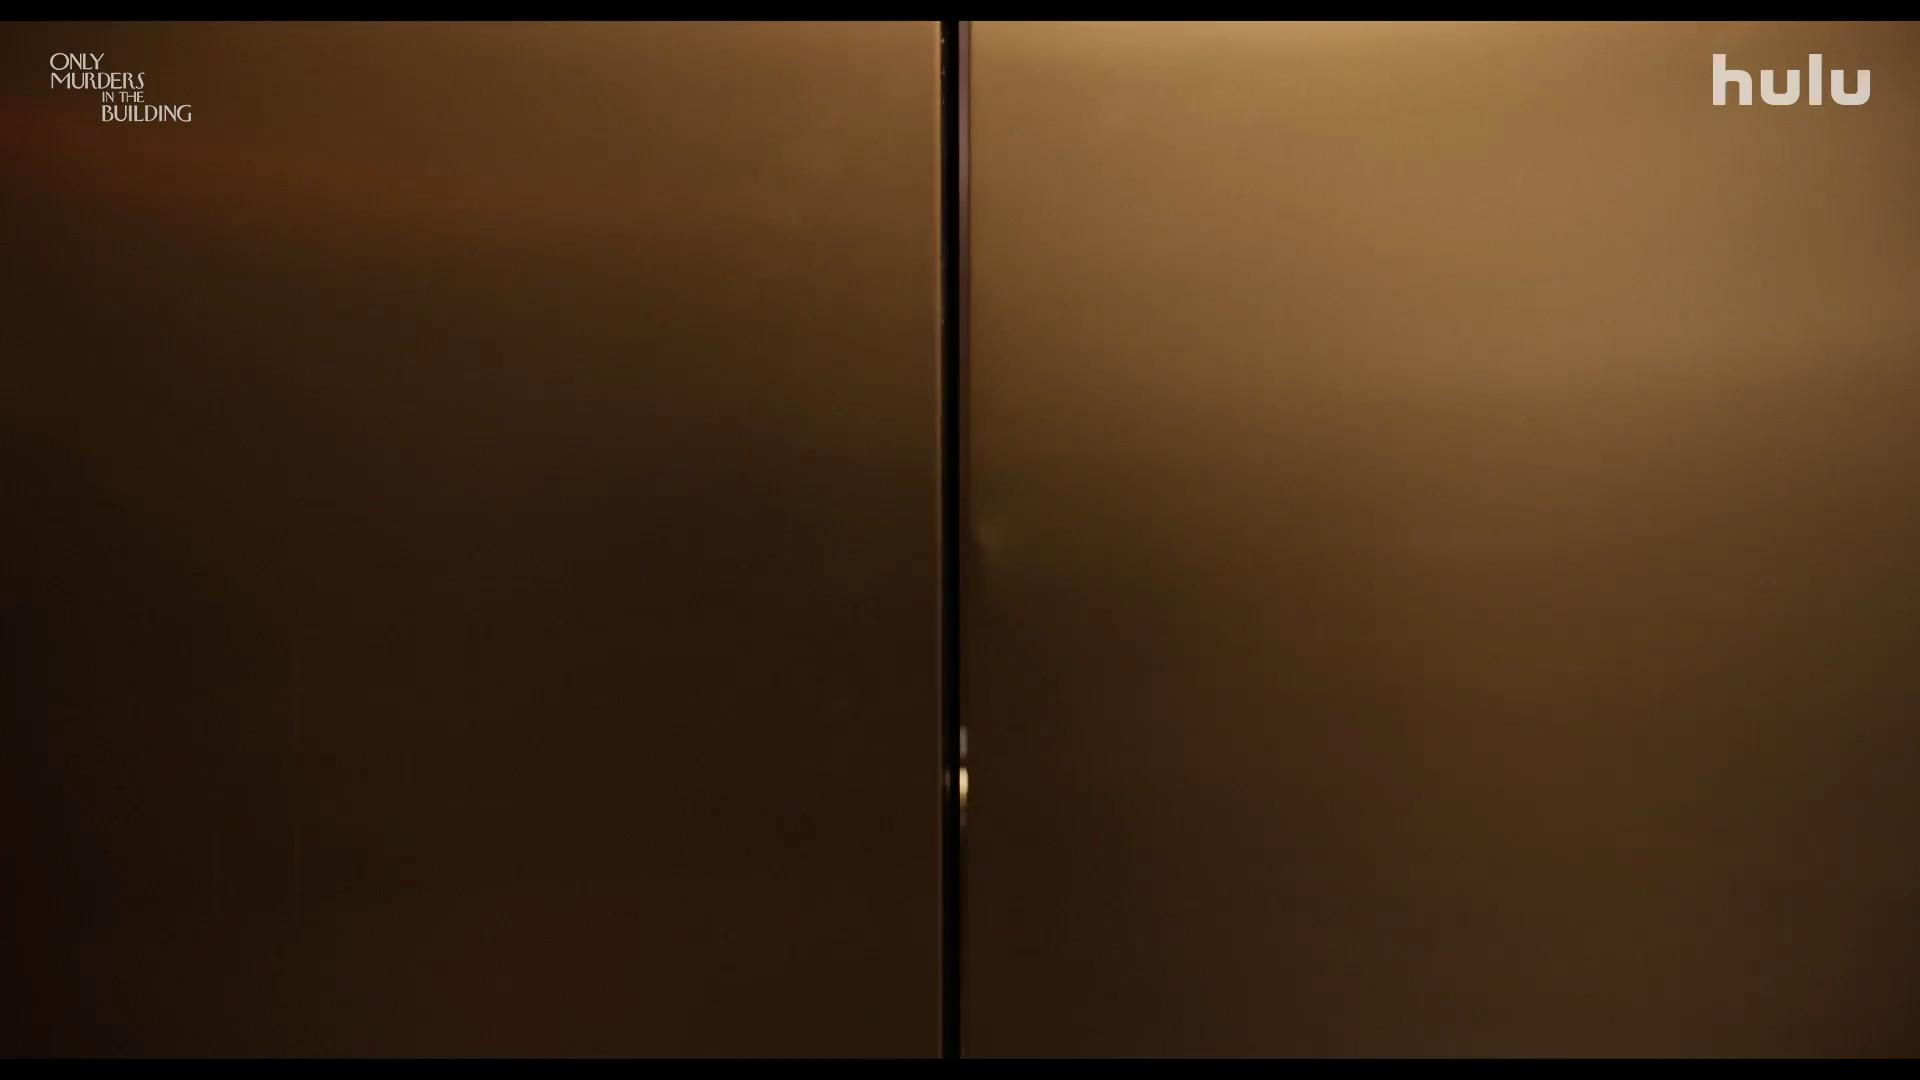
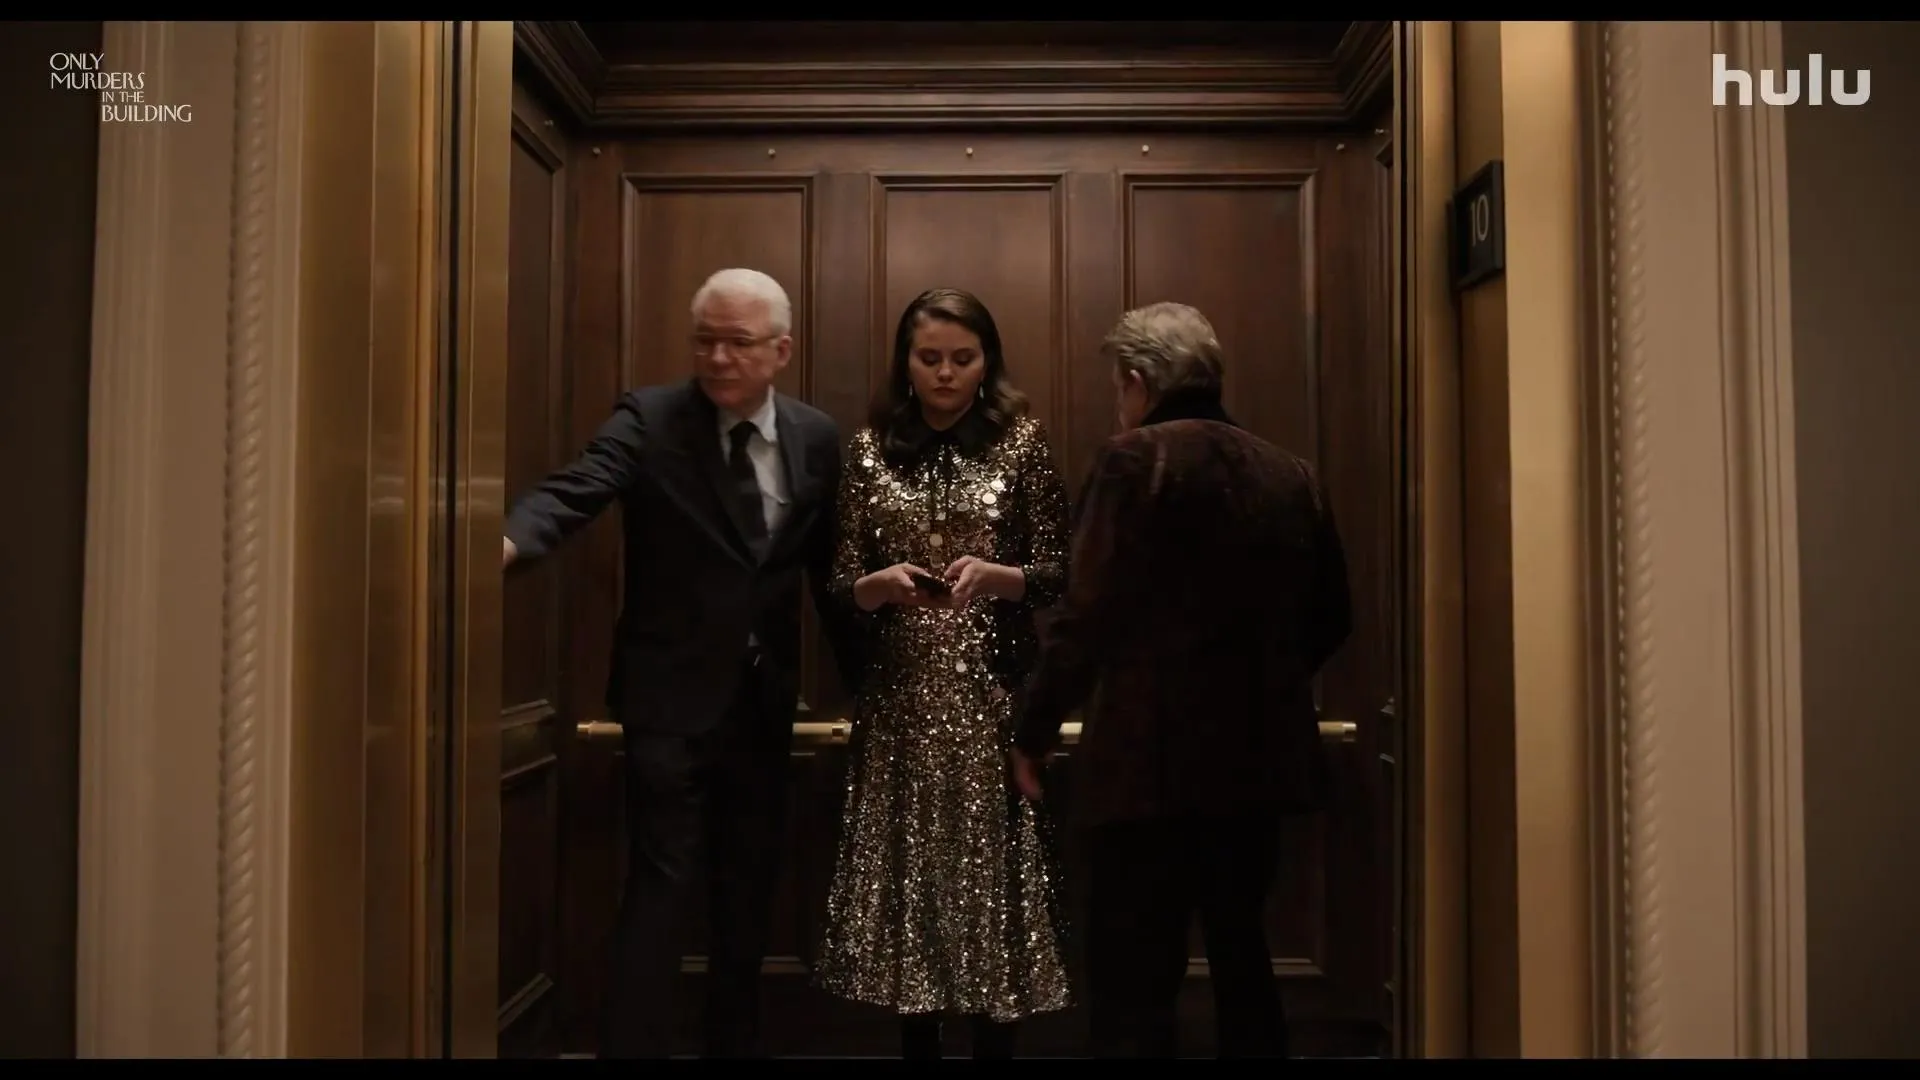
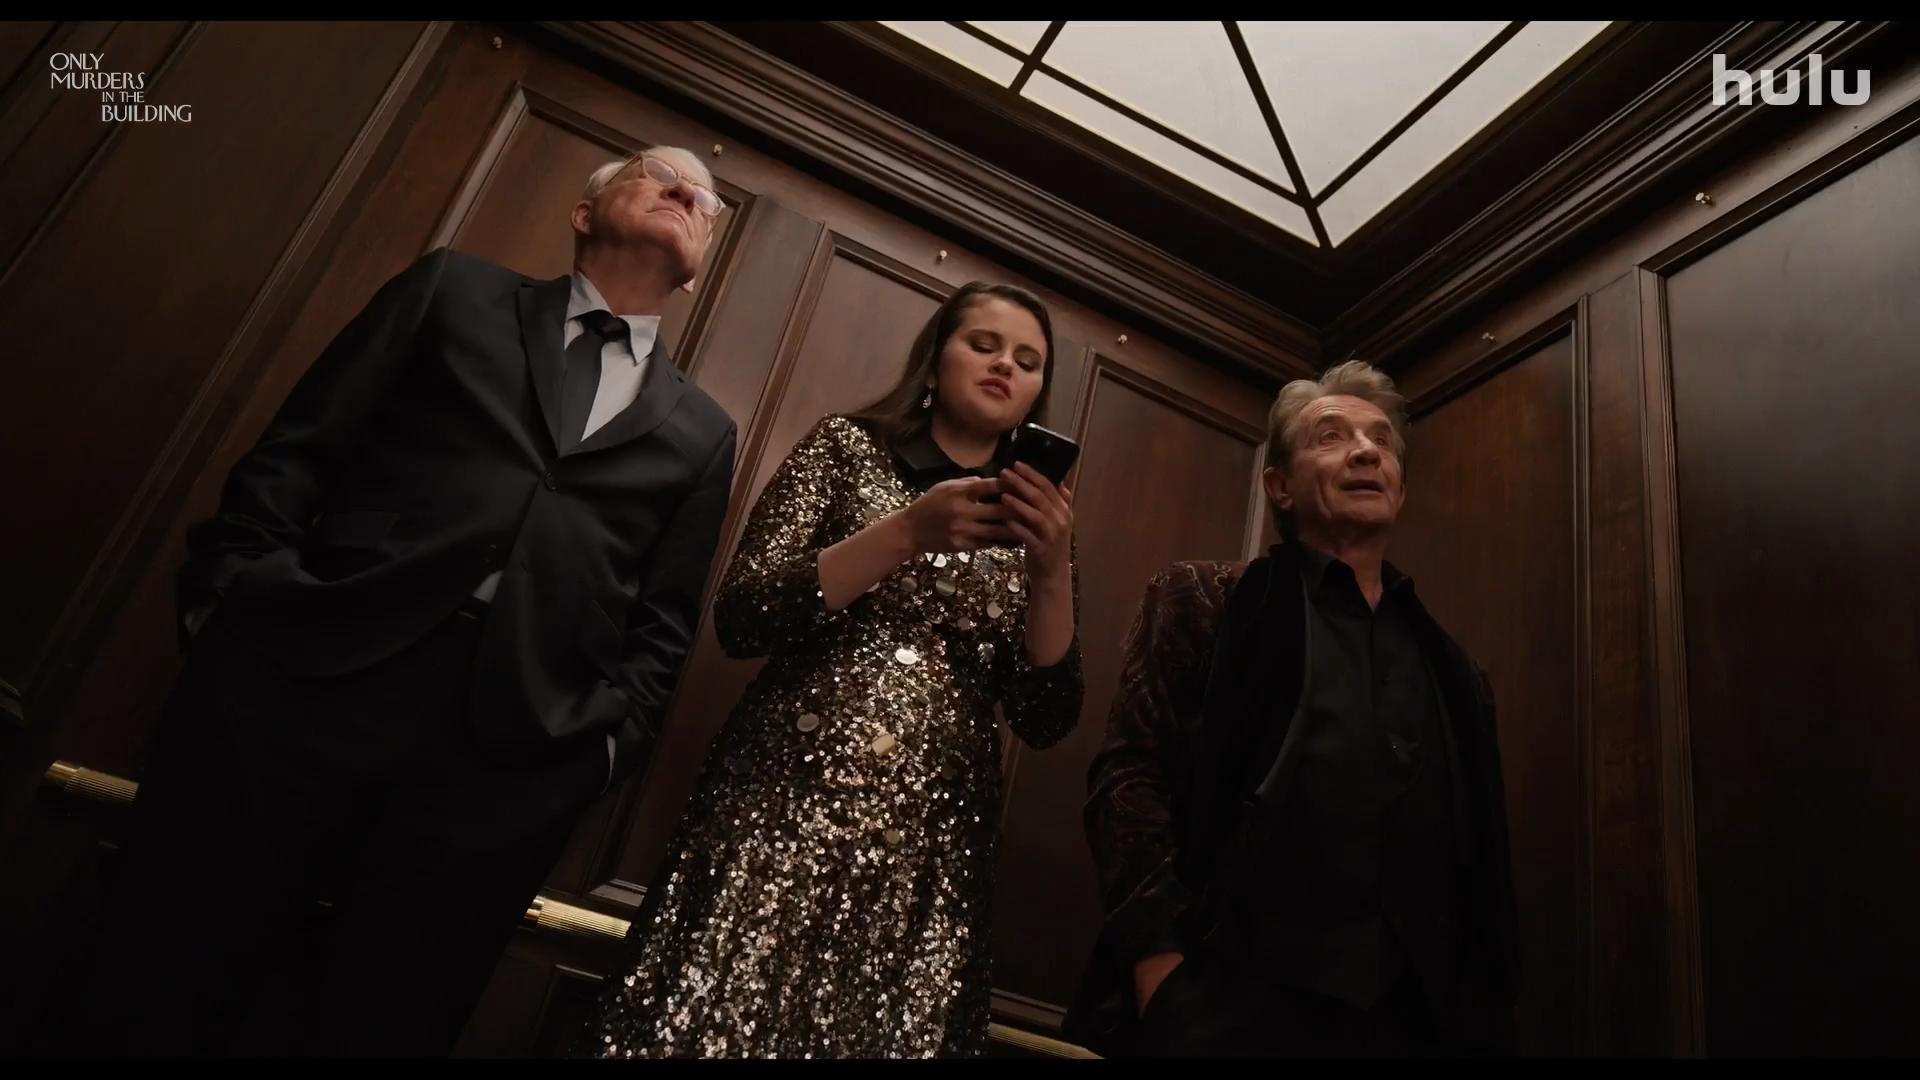
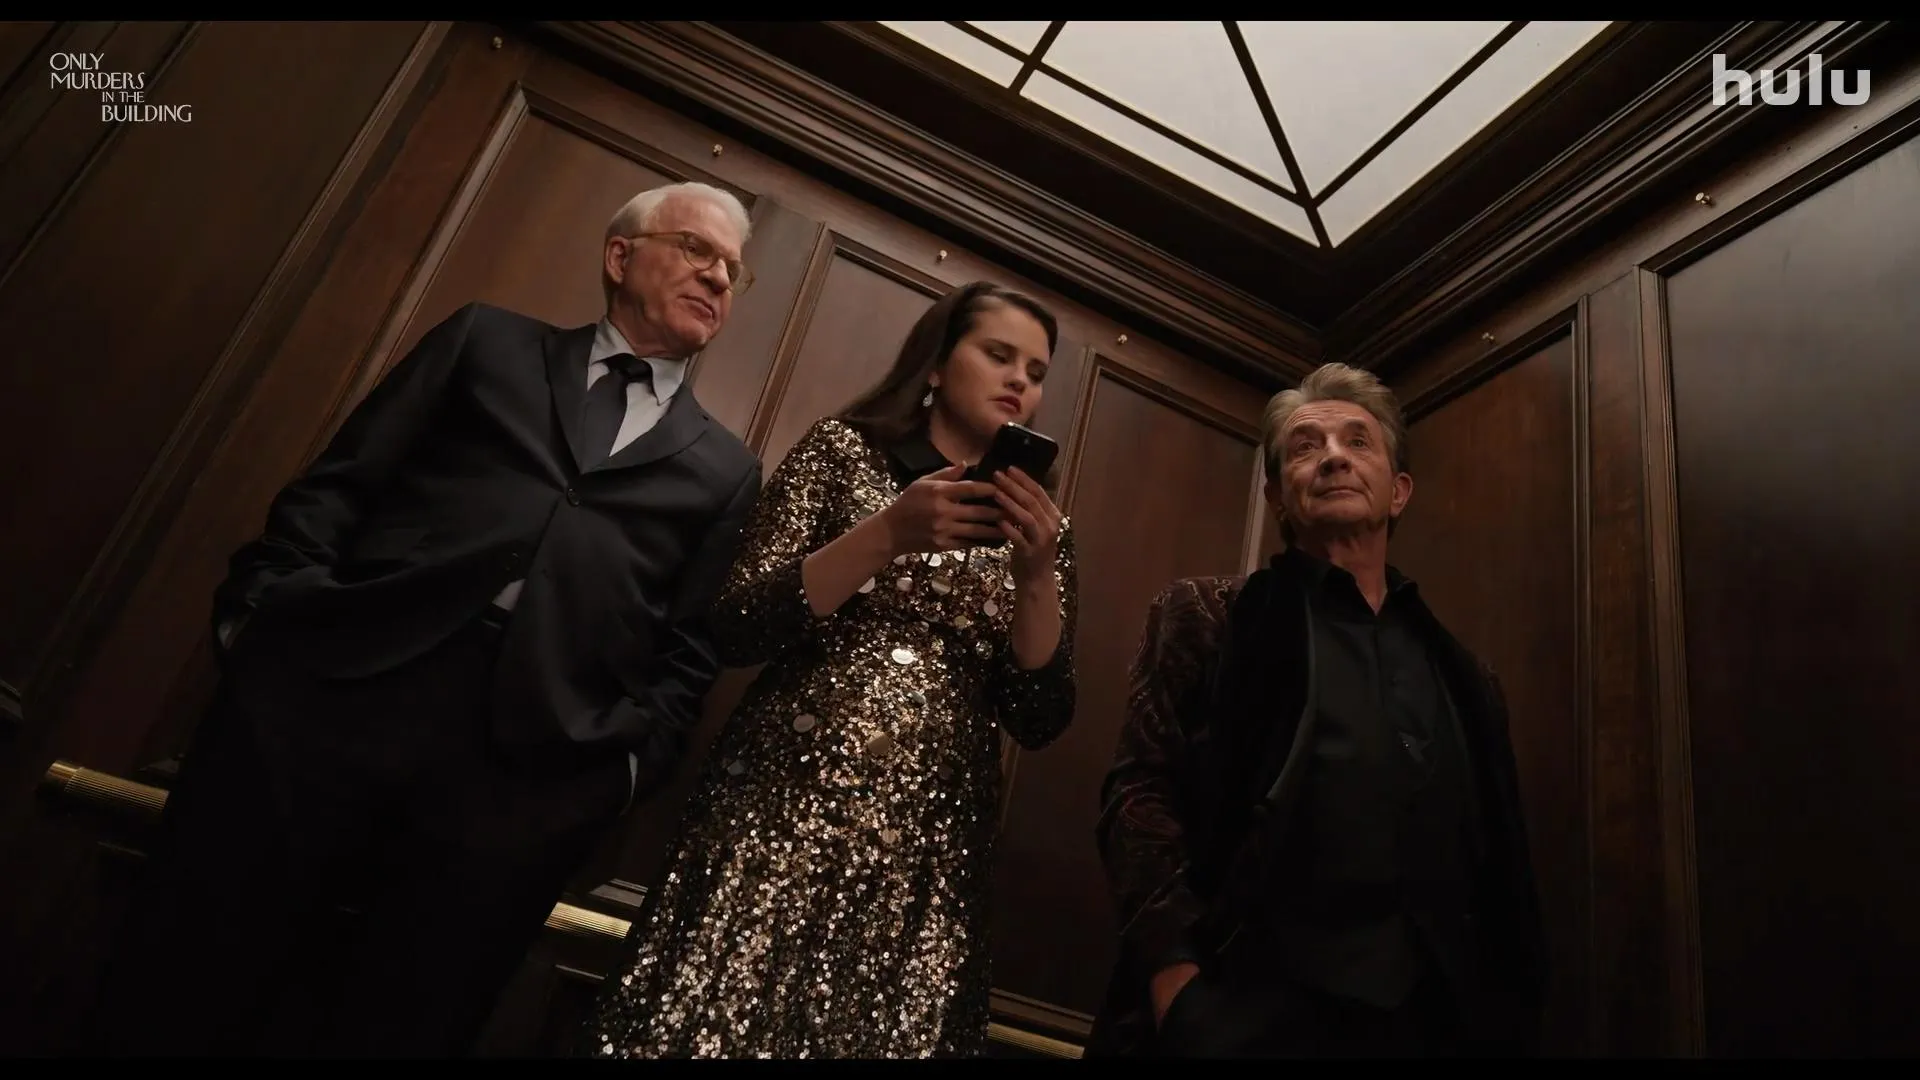
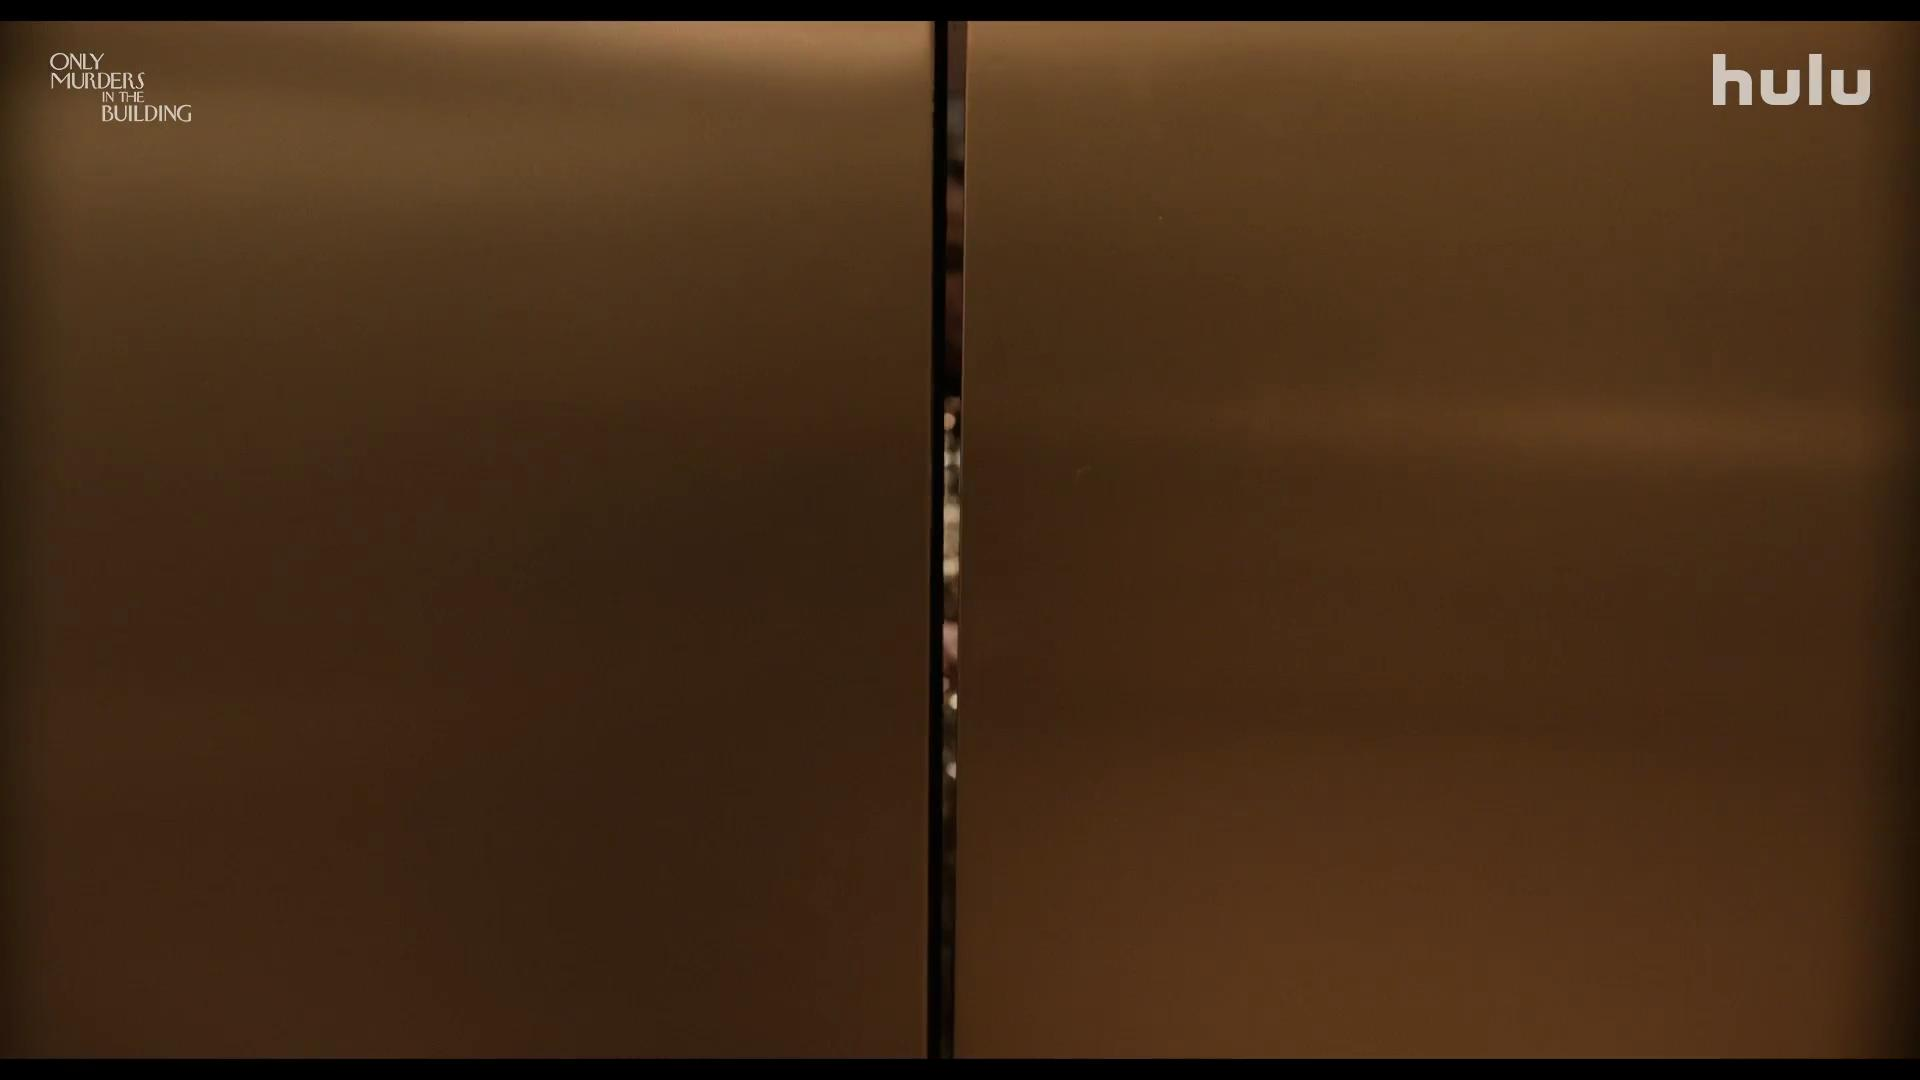
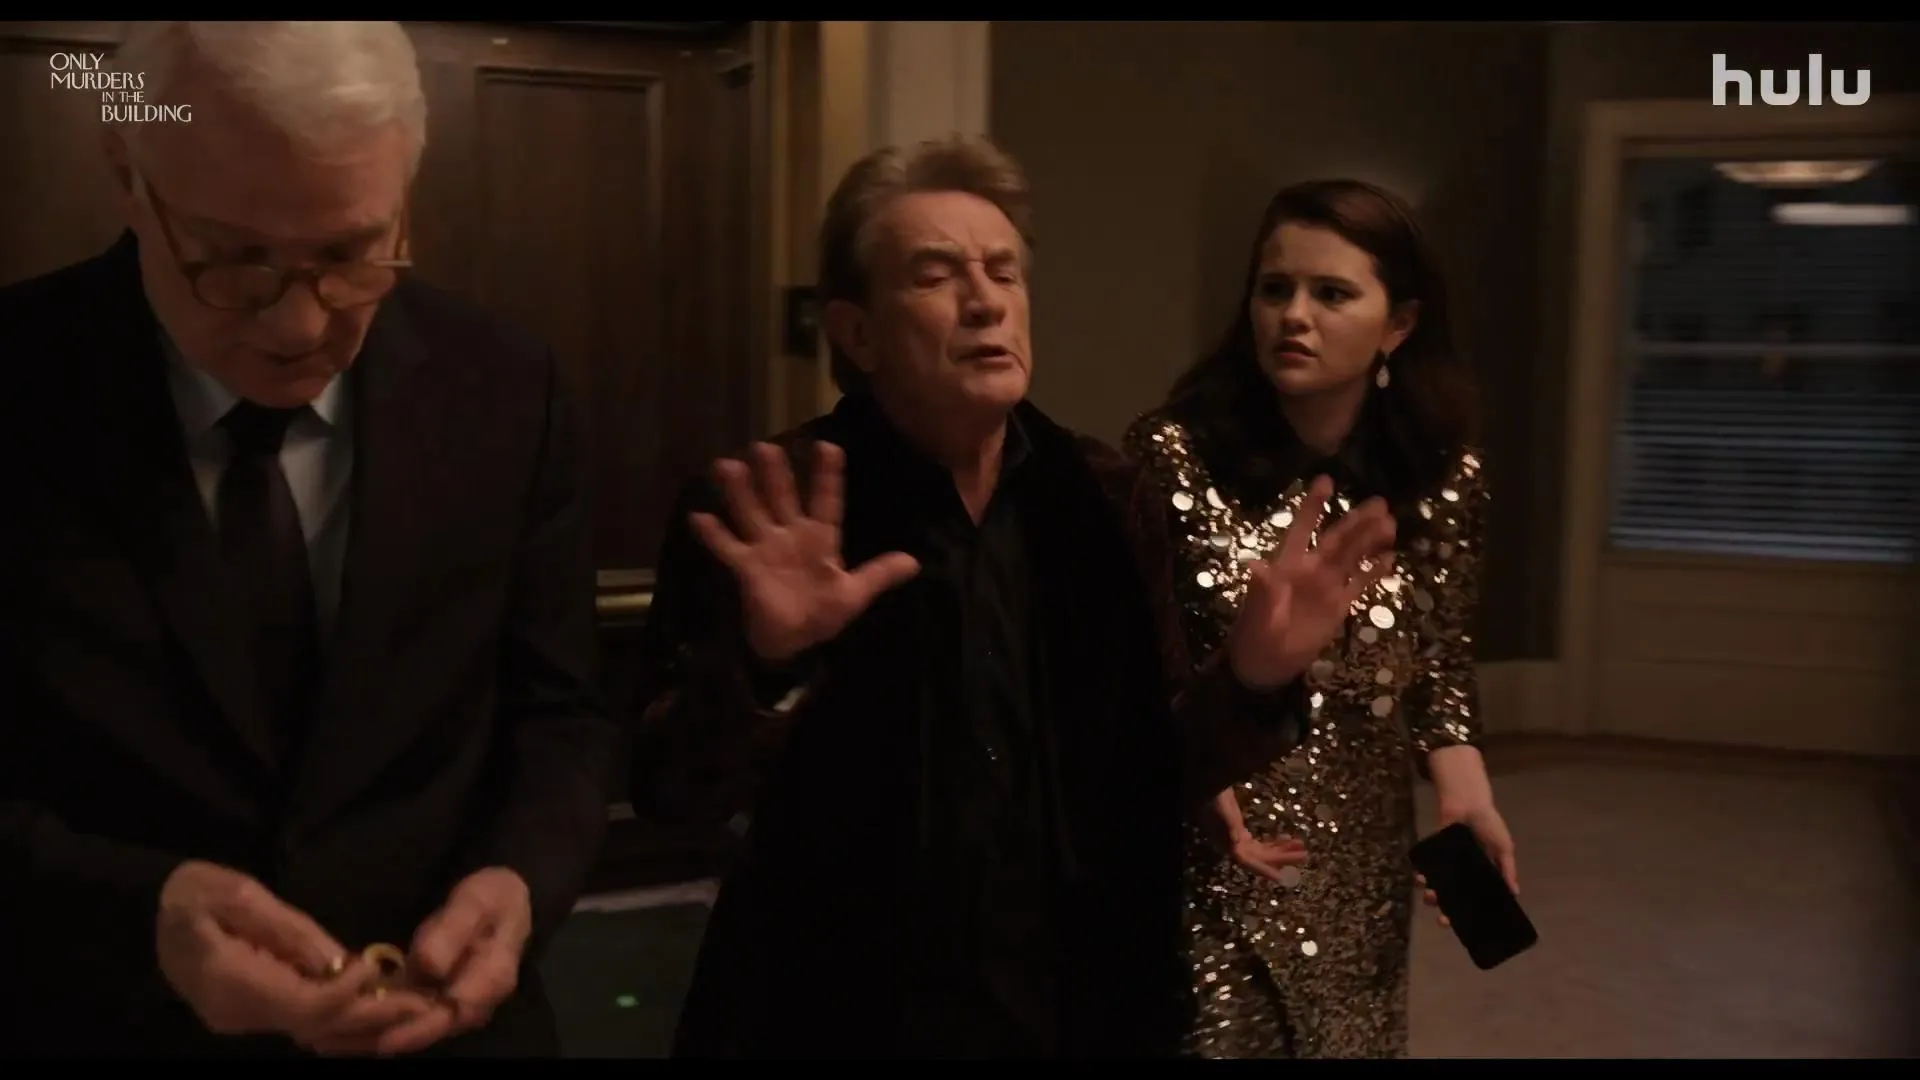

In [10]:
scene_view.select(scene_view.pos, scene_view.video_segment, scene_view.beginning_frame).tail(3)

## 02 - Build Scene Prompts

Now let's generate scene descriptions that we can use to create images and videos. We'll write two custom UDFs (User-Defined Functions):

1. **`build_scene_prompt()`** - Composes a text prompt using movie info (title, plot, transcript) and a prompt template
2. **`extract_text()`** - Extracts the generated text from Gemini's JSON output

Here's the workflow:

1. `build_scene_prompt()` composes the text prompt (no AI needed here)
2. We pass the text prompt + frame image to Gemini
3. Gemini returns a JSON response with the scene description
4. `extract_text()` extracts the text from the JSON

The prompt template in `build_scene_prompt()` follows best practices from Google's [guide to prompting Gemini for image generation](https://developers.googleblog.com/en/how-to-prompt-gemini-2-5-flash-image-generation-for-the-best-results/), which emphasizes describing scenes narratively with specific details about lighting, camera angles, and mood.

In [11]:
@pxt.udf
def build_scene_prompt(
    title: str,
    promo_text: str, 
    transcript_text: str,
    content_type: str = 'image'
) -> str:
    """Build the text prompt for Gemini to generate scene descriptions.
    
    Args:
        title: Movie title
        promo_text: Movie plot description
        transcript_text: Scene transcript
        content_type: Either 'image' or 'video' to customize the prompt
    """
    # Add video-specific instruction if generating video
    video_or_image_style = (
        'animated in a stop-motion claymation style with subtle, handcrafted movements. '
        if content_type == 'video' 
        else 'photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. '
    )
    
    return (
        'You are creating a miniature diorama scene. '
        f'Movie: "{title}". '
        f'Plot: {promo_text}. '
        f'This frame shows a key moment where: {transcript_text}. '
        f'Create a detailed prompt for {"a video" if content_type == "video" else "an image"} generator following this structure: '
        'An intricate miniature diorama of [describe the scene], '
        f'{video_or_image_style}'
        'Describe the shot type, lighting (emphasize dramatic miniature lighting), '
        'tiny handcrafted details, materials (felt, clay, wood), color palette, and mood. '
        'The scene should feel both cinematic and charmingly handmade. '
        'Write only the prompt, no preamble or explanation. '
        f'Do not include text, typography, or words in the {content_type}.'
    )

In [18]:
# Build the text prompt for each scene
scene_view.add_computed_column(
    prompt_text=build_scene_prompt(
        scene_view.title,
        scene_view.promo_text,
        scene_view.transcript_text
    ),
    if_exists='replace'
)

Added 18 column values with 0 errors in 0.04 s (482.10 rows/s)


18 rows updated.

In [19]:
scene_view

view 'scene_view' (of 'primetime_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              audio  Required[Audio]                       extract_audio(video_segment)
      transcription   Required[Json]                    transcribe(audio, model='base')
    transcript_text           String                  transcription.text.astype(String)
    transcript_lang           String              transcription.language.astype(String)
    beginning_frame            Image           video_segment.extract_frame(timestamp=5)
    prompt_response           String  build_scene_prompt(title, promo_text, transcri...
        prompt_text           String  build_scene_prompt(title, promo_text, transcri...
              video            Video                                                   
              title           String                                                   
          promo_img            Image                                                   
         promo_text           String                                                   
           duration            Float                                get_duration(video)
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

So we have `prompt_text` as a new column in our view schema. Let's look at two of them:

beginning_frame,prompt_text
,"You are creating a miniature diorama scene. Movie: ""The Queens Gambit"". Plot: Set during the Cold War era, orphaned chess prodigy Beth Harmon struggles with addiction in a quest to become the greatest chess player in the world.. This frame shows a key moment where: That check has been the whole point of the sequence beginning with the bishop cutting down the slope of the book by forcing it to a last threatening left. Question is... What will she do now?. Create a detailed prompt for an imag ...... g this structure: An intricate miniature diorama of [describe the scene], photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Describe the shot type, lighting (emphasize dramatic miniature lighting), tiny handcrafted details, materials (felt, clay, wood), color palette, and mood. The scene should feel both cinematic and charmingly handmade. Write only the prompt, no preamble or explanation. Do not include text, typography, or words in the image."

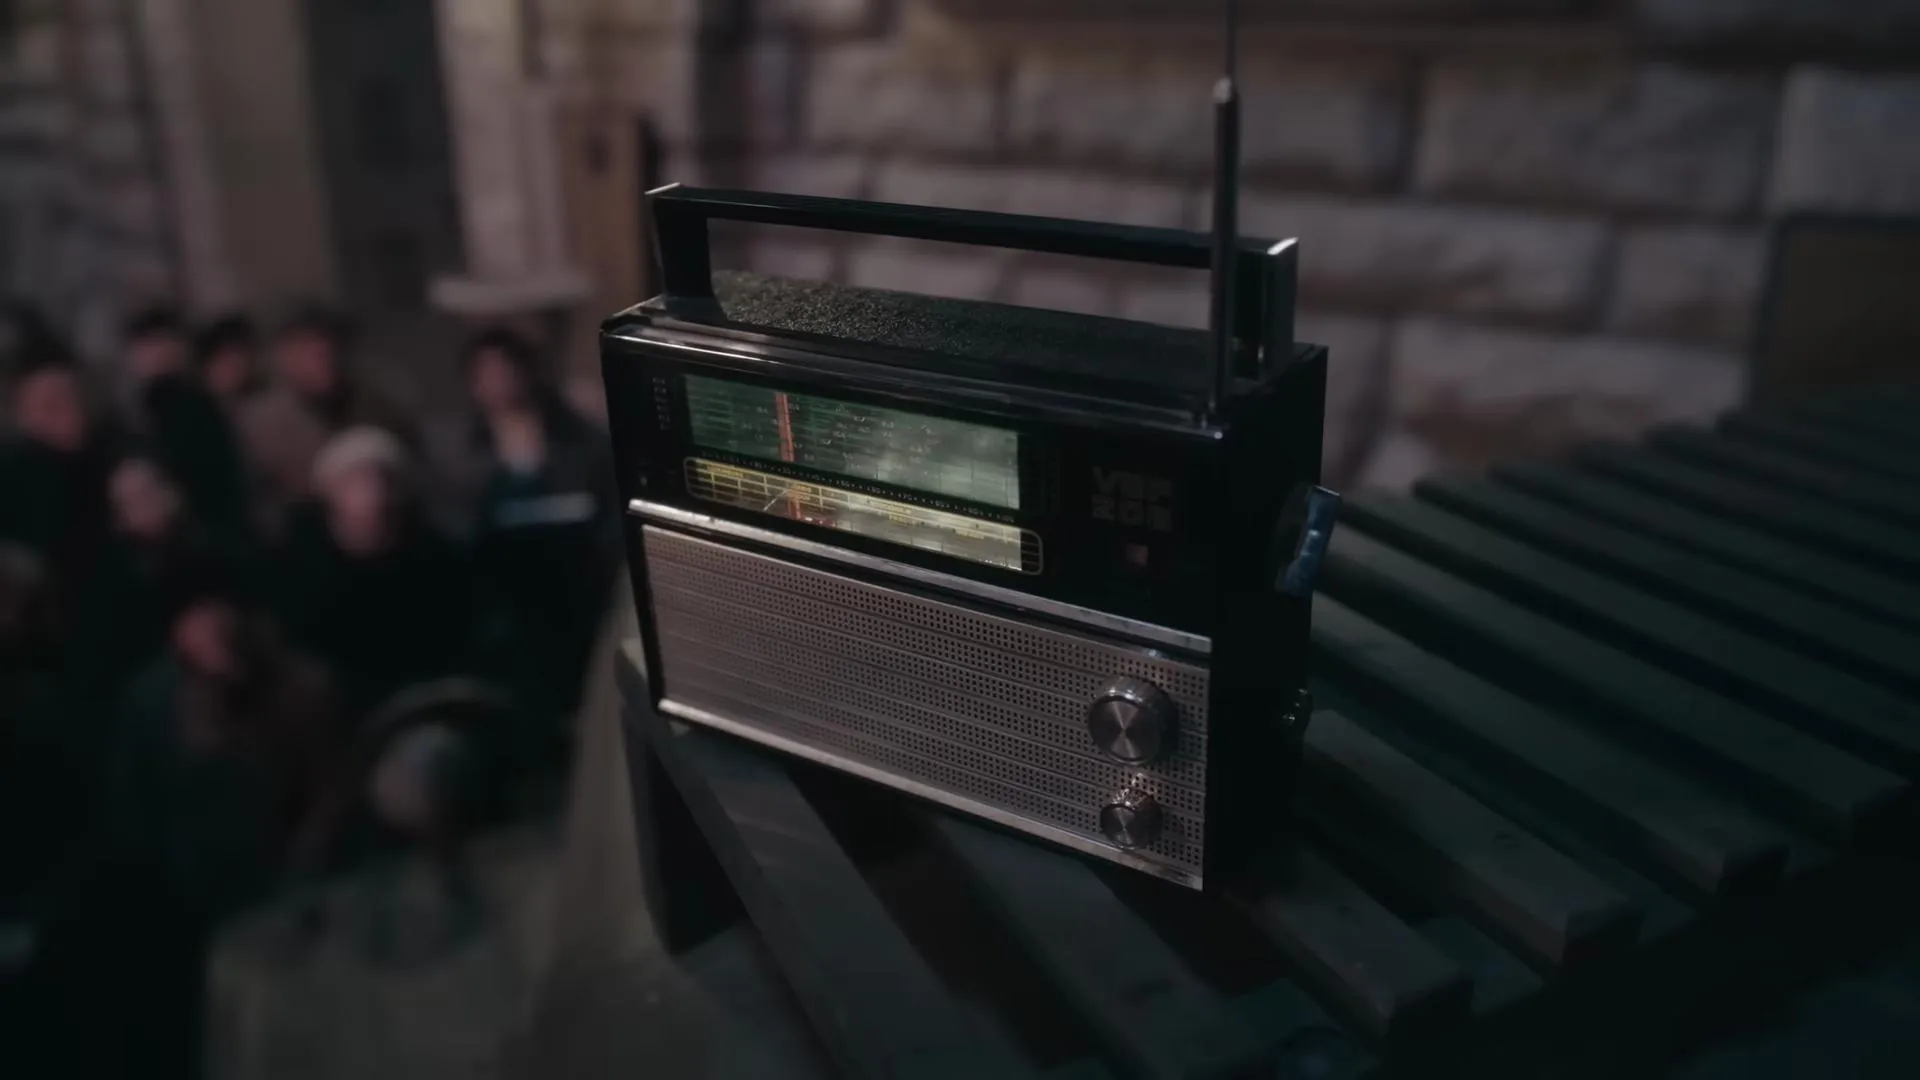

In [20]:
scene_view.select(scene_view.beginning_frame, scene_view.prompt_text).head(1)

beginning_frame,prompt_text
,"You are creating a miniature diorama scene. Movie: ""Only Murders in the Building"". Plot: Three strangers share an obsession with true crime and suddenly find themselves wrapped up in one. When a grisly death occurs inside their exclusive Upper West Side apartment building, the trio suspects murder and employs their precise knowledge of true crime to investigate the truth. Perhaps even more explosive are the lies they tell one another. Soon, the endangered trio comes to realize a killer might ...... g this structure: An intricate miniature diorama of [describe the scene], photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Describe the shot type, lighting (emphasize dramatic miniature lighting), tiny handcrafted details, materials (felt, clay, wood), color palette, and mood. The scene should feel both cinematic and charmingly handmade. Write only the prompt, no preamble or explanation. Do not include text, typography, or words in the image."

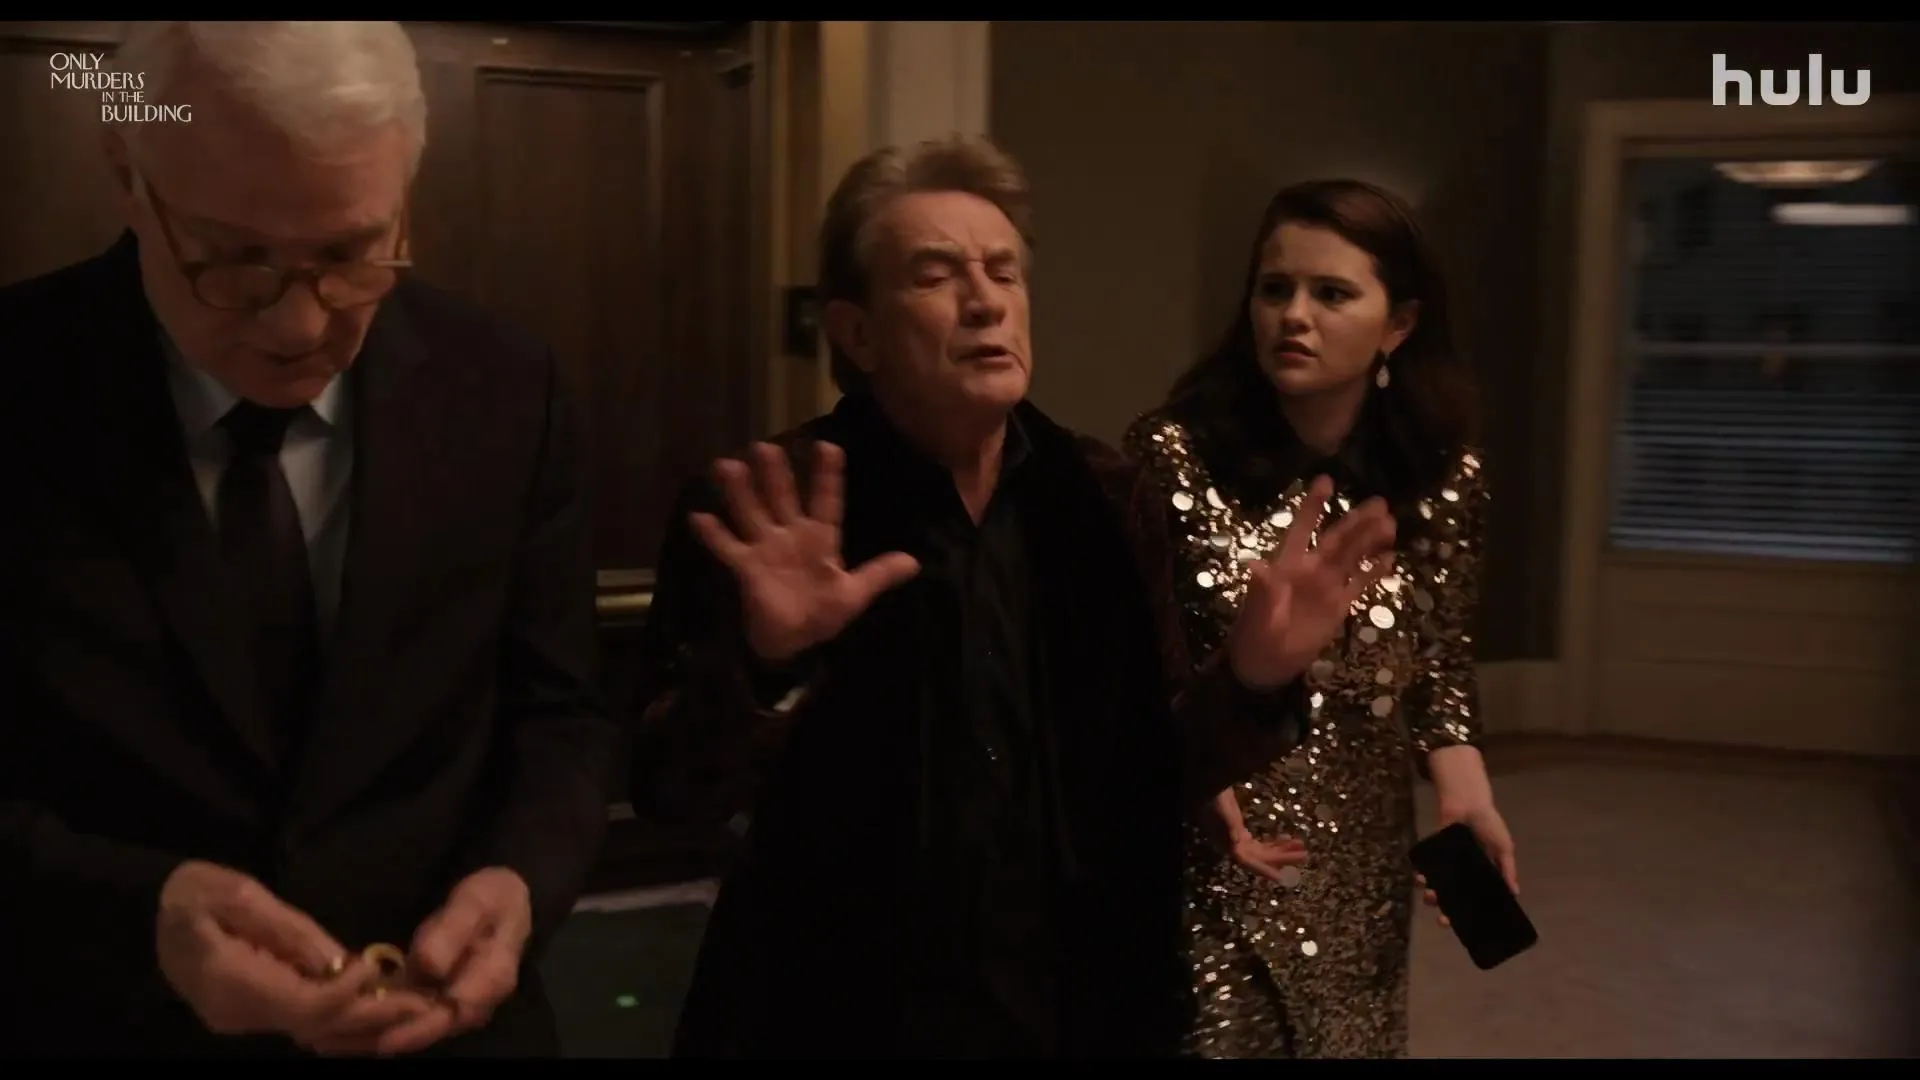

In [21]:
scene_view.select(scene_view.beginning_frame, scene_view.prompt_text).tail(1)

## 03 - Generate AI Prompts

Now we'll actually use these text prompts to generate scene prompts for AI image/video models. 

Recall from Act 01 that writing a query using `select()` does not change the underlying table - you can think of this like a purely "in memory" operation that is great for experimentation and transparency in your workflow. But in this chunk we are calling the Gemini model:

beginning_frame,prompt_text,scene_prompt
,"You are creating a miniature diorama scene. Movie: ""The Queens Gambit"". Plot: Set during the Cold War era, orphaned chess prodigy Beth Harmon struggles with addiction in a quest to become the greatest chess player in the world.. This frame shows a key moment where: You're gonna miss the flood? Come on. Come on. Lisa, come on.. Create a detailed prompt for an image generator following this structure: An intricate miniature diorama of [describe the scene], photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Describe the shot type, lighting (emphasize dramatic miniature lighting), tiny handcrafted details, materials (felt, clay, wood), color palette, and mood. The scene should feel both cinematic and charmingly handmade. Write only the prompt, no preamble or explanation. Do not include text, typography, or words in the image.","{""sdk_http_response"": {""headers"": {""Content-Type"": ""application/json; charset=UTF-8"", ""Vary"": ""Origin, X-Origin, Referer"", ""Content-Encoding"": ""gzip"", ""Date"": ""Wed, 28 Jan 2026 01:33:05 GMT"", ""Server"": ""scaffolding on HTTPServer2"", ""X-XSS-Protection"": ""0"", ""X-Frame-Options"": ""SAMEORIGIN"", ""X-Content-Type-Options"": ""nosniff"", ""Server-Timing"": ""gfet4t7; dur=2761"", ""Alt-Svc"": ""h3=\"":443\""; ma=2592000,h3-29=\"":443\""; ma=2592000"", ""Transfer-Encoding"": ""chunked""}, ""body"": null}, ""candidates"": [{""content"": {""parts"": [{""media_resolution"": null, ""code_execution_result"": null, ""executable_code"": null, ""file_data"": null, ""function_call"": null, ""function_response"": null, ""inline_data"": null, ""text"": ""An intricate miniature diorama of Beth Harmon, in a handmade white wool coat and beret, standing on a miniature cobblestone sidewalk next to a lar ...... phasis on whites, blacks, and greys, accented by the pale red of Beth's hair. Mood is melancholic yet hopeful, cinematic and charmingly handmade.\n"", ""thought"": null, ""thought_signature"": null, ""video_metadata"": null}], ""role"": ""model""}, ""citation_metadata"": null, ""finish_message"": null, ""token_count"": null, ""finish_reason"": ""STOP"", ""avg_logprobs"": -0.666, ""grounding_metadata"": null, ""index"": null, ""logprobs_result"": null, ""safety_ratings"": null, ""url_context_metadata"": null}], ""create_time"": null, ""model_version"": ""gemini-2.0-flash"", ""prompt_feedback"": null, ""response_id"": ""T2d5abz4EJ3h_uMPh9XBsAs"", ""usage_metadata"": {""cache_tokens_details"": null, ""cached_content_token_count"": null, ""candidates_token_count"": 192, ""candidates_tokens_details"": [{""modality"": ""TEXT"", ""token_count"": 192}], ""prompt_token_count"": 1988, ""prompt_tokens_details"": [{""modality"": ""TEXT"", ""token_count"": 182}, {""modality"": ""IMAGE"", ""token_count"": 1806}], ""thoughts_token_count"": null, ""tool_use_prompt_token_count"": null, ""tool_use_prompt_tokens_details"": null, ""total_token_count"": 2180, ""traffic_type"": null}, ""automatic_function_calling_history"": [], ""parsed"": null}"
,"You are creating a miniature diorama scene. Movie: ""Only Murders in the Building"". Plot: Three strangers share an obsession with true crime and suddenly find themselves wrapped up in one. When a grisly death occurs inside their exclusive Upper West Side apartment building, the trio suspects murder and employs their precise knowledge of true crime to investigate the truth. Perhaps even more explosive are the lies they tell one another. Soon, the endangered trio comes to realize a killer might ...... g this structure: An intricate miniature diorama of [describe the scene], photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Describe the shot type, lighting (emphasize dramatic miniature lighting), tiny handcrafted details, materials (felt, clay, wood), color palette, and mood. The scene should feel both cinematic and charmingly handmade.
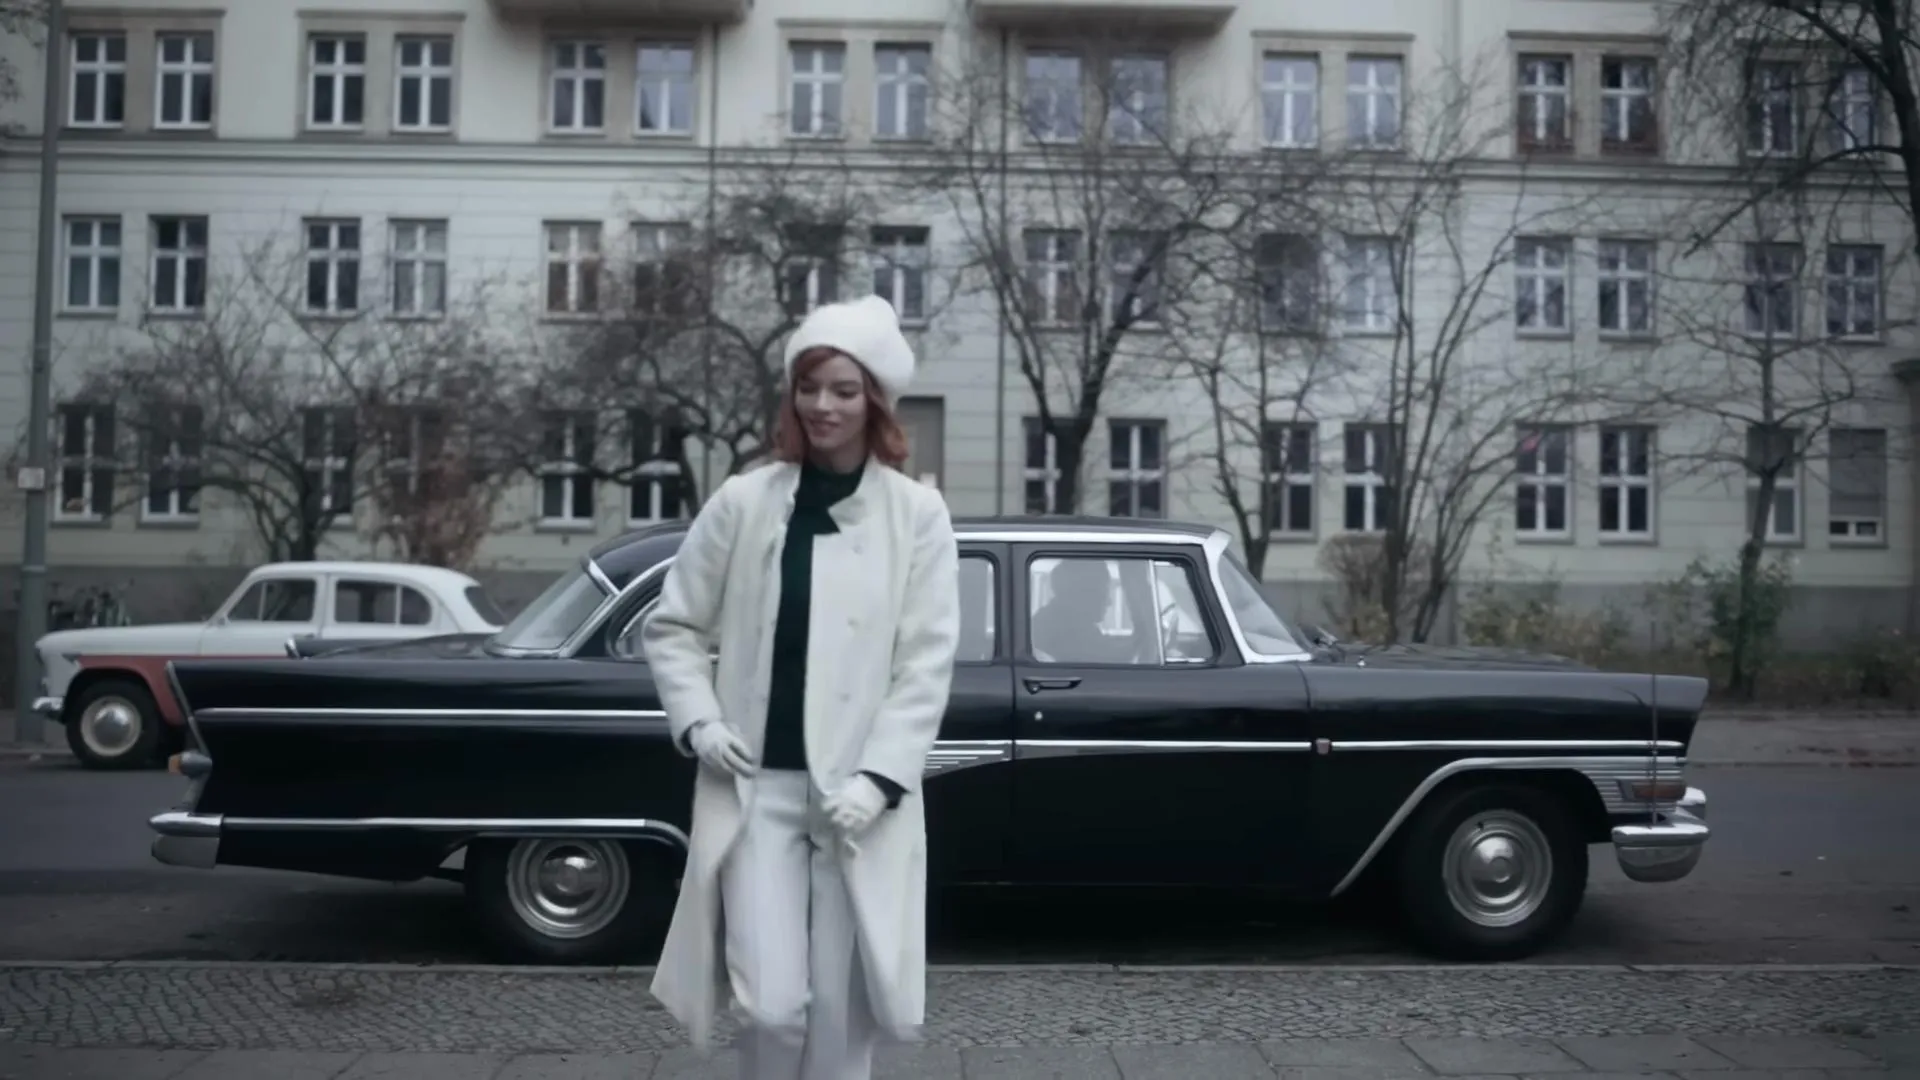
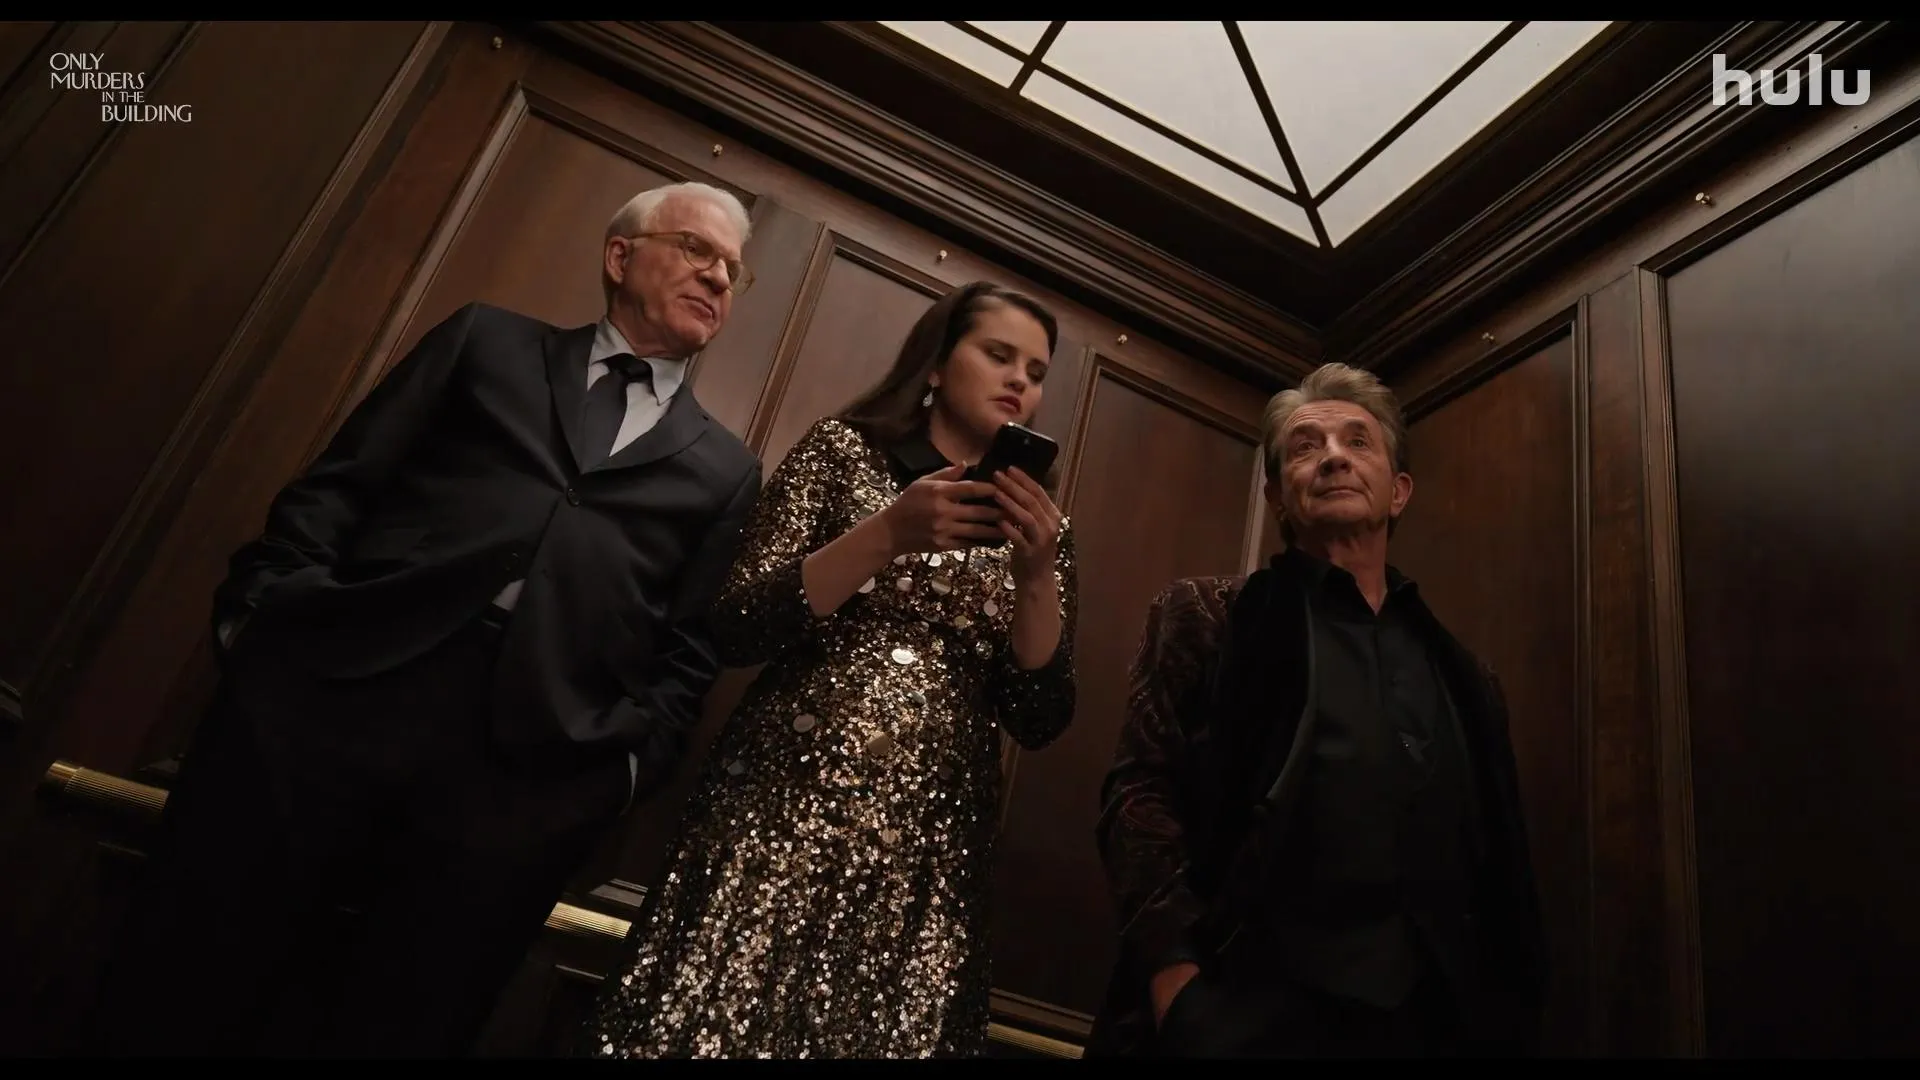

In [26]:
# Test on a single scene
scene_view.where(scene_view.pos == 6).select(
    scene_view.beginning_frame,
    scene_view.prompt_text,
    scene_prompt=pxtf.gemini.generate_content(
        contents=[
            scene_view.prompt_text,
            scene_view.beginning_frame
        ],
        model='gemini-2.0-flash'
    )
).collect()

You can see that Gemini returns JSON output that needs to be parsed, because we only want the text. We are going to fast-forward through this by writing a UDF to extract the text we need.

In [30]:
@pxt.udf
def extract_text(response: dict) -> str:
    """Extract the generated text from Gemini's response."""
    return response['candidates'][0]['content']['parts'][0]['text']

So now we've called the Gemini API for two scenes (one from each video). Our view table remains unchanged:

In [28]:
scene_view

view 'scene_view' (of 'primetime_vids')

        Column Name             Type                                      Computed With
                pos    Required[Int]                                                   
      segment_start            Float                                                   
  segment_start_pts              Int                                                   
        segment_end            Float                                                   
    segment_end_pts              Int                                                   
      video_segment  Required[Video]                                                   
              audio  Required[Audio]                       extract_audio(video_segment)
      transcription   Required[Json]                    transcribe(audio, model='base')
    transcript_text           String                  transcription.text.astype(String)
    transcript_lang           String              transcription.language.astype(String)
    beginning_frame            Image           video_segment.extract_frame(timestamp=5)
    prompt_response           String  build_scene_prompt(title, promo_text, transcri...
        prompt_text           String  build_scene_prompt(title, promo_text, transcri...
              video            Video                                                   
              title           String                                                   
          promo_img            Image                                                   
         promo_text           String                                                   
           duration            Float                                get_duration(video)
             scenes             Json  video.scene_detect_histogram(fps=10,\n    thre...

Now let's add our AI-generated scene prompt as a computed column, and extract just the text we need from the Gemini response.

- This calls the Gemini API for each scene and saves the output in a column in our table persistently. 
- This will take longer (>1 minute) to generate the output because we are generating across all rows in our table. 
- We use our `extract_text` UDF to parse the response as another computed column (that depends on `prompt_response`)

In [31]:
scene_view.add_computed_column(
    prompt_response=pxtf.gemini.generate_content(
        contents=[
            scene_view.prompt_text,
            scene_view.beginning_frame
        ],
        model='gemini-2.0-flash'
    ), if_exists='replace')

scene_view.add_computed_column(
    scene_prompt=extract_text(scene_view.prompt_response),
    if_exists='replace'
)

Added 18 column values with 0 errors in 5.77 s (3.12 rows/s)
Added 18 column values with 0 errors in 0.03 s (582.91 rows/s)


18 rows updated.

In [32]:
scene_view

view 'scene_view' (of 'primetime_vids')

        Column Name              Type                                      Computed With
                pos     Required[Int]                                                   
      segment_start             Float                                                   
  segment_start_pts               Int                                                   
        segment_end             Float                                                   
    segment_end_pts               Int                                                   
      video_segment   Required[Video]                                                   
              audio   Required[Audio]                       extract_audio(video_segment)
      transcription    Required[Json]                    transcribe(audio, model='base')
    transcript_text            String                  transcription.text.astype(String)
    transcript_lang            String              transcription.language.astype(String)
    beginning_frame             Image           video_segment.extract_frame(timestamp=5)
        prompt_text            String  build_scene_prompt(title, promo_text, transcri...
    prompt_response    Required[Json]  generate_content(contents=[prompt_text, beginn...
       scene_prompt  Required[String]                      extract_text(prompt_response)
              video             Video                                                   
              title            String                                                   
          promo_img             Image                                                   
         promo_text            String                                                   
           duration             Float                                get_duration(video)
             scenes              Json  video.scene_detect_histogram(fps=10,\n    thre...

beginning_frame,scene_prompt
,"An intricate miniature diorama of Beth Harmon in a white outfit skipping in front of a large black vintage car on a Cold War Berlin street, a white and red vintage car parked behind it, with a large building with many windows and bare trees in the background, photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Medium shot, dramatic miniature lighting with soft shadows and subtle light bloom, tiny handcrafted details such as cobblestone texture on the sidewalk and individual bricks on the building, using materials like felt for clothing, clay for figures, and balsa wood for the cars and buildings, a desaturated color palette with whites, blacks, greys, and muted reds, creating a melancholic yet hopeful mood. The scene should feel both cinematic and charmingly handmade."
,"An intricate miniature diorama of a hallway scene from ""Only Murders in the Building,"" featuring miniature versions of Charles, Oliver, and Mabel. Charles examines a tiny cork in his hands, sculpted from clay, wearing a felt suit. Oliver, in a hand-stitched velvet coat, throws his hands up in exasperation, while Mabel, dressed in a sequined felt dress, looks on anxiously, a minuscule cell phone clutched in her hand. The hallway is constructed from painted wood, with tiny, imperfect details like uneven baseboards and miniature textured wallpaper. Close-up shot, photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. The lighting is dramatic, a single miniature LED spotlight mimicking overhead lighting, casting long, exaggerated shadows. Color palette is muted beige, brown, and gold, with pops of the dark velvet and sequins. The mood is tense and slightly comedic, with a hint of mystery."
,"An intricate miniature diorama of the interior of a cramped, vintage elevator in an old New York apartment building, crafted with meticulous detail. Three miniature figures, one in a dark suit, another in a shimmering gold sequined dress holding a tiny phone, and the last in a velvet jacket, are posed looking upwards, seemingly trapped. The elevator walls are paneled with dark wood crafted from balsa wood, meticulously textured to mimic wood grain. Above, a detailed recreation of the elevato ...... ing up at the figures. Dramatic miniature lighting is achieved with tiny LED spotlights casting long shadows and highlighting the texture of the materials; light bounces off the sequined dress. The figures are crafted from clay and felt. The color palette is dominated by rich browns, gold, and blacks, creating a mood of suspense and mystery. The entire scene is photographed with a tilt-shift lens creating selective focus, blurring the edges and enhancing the dreamlike, toy-world atmosphere."

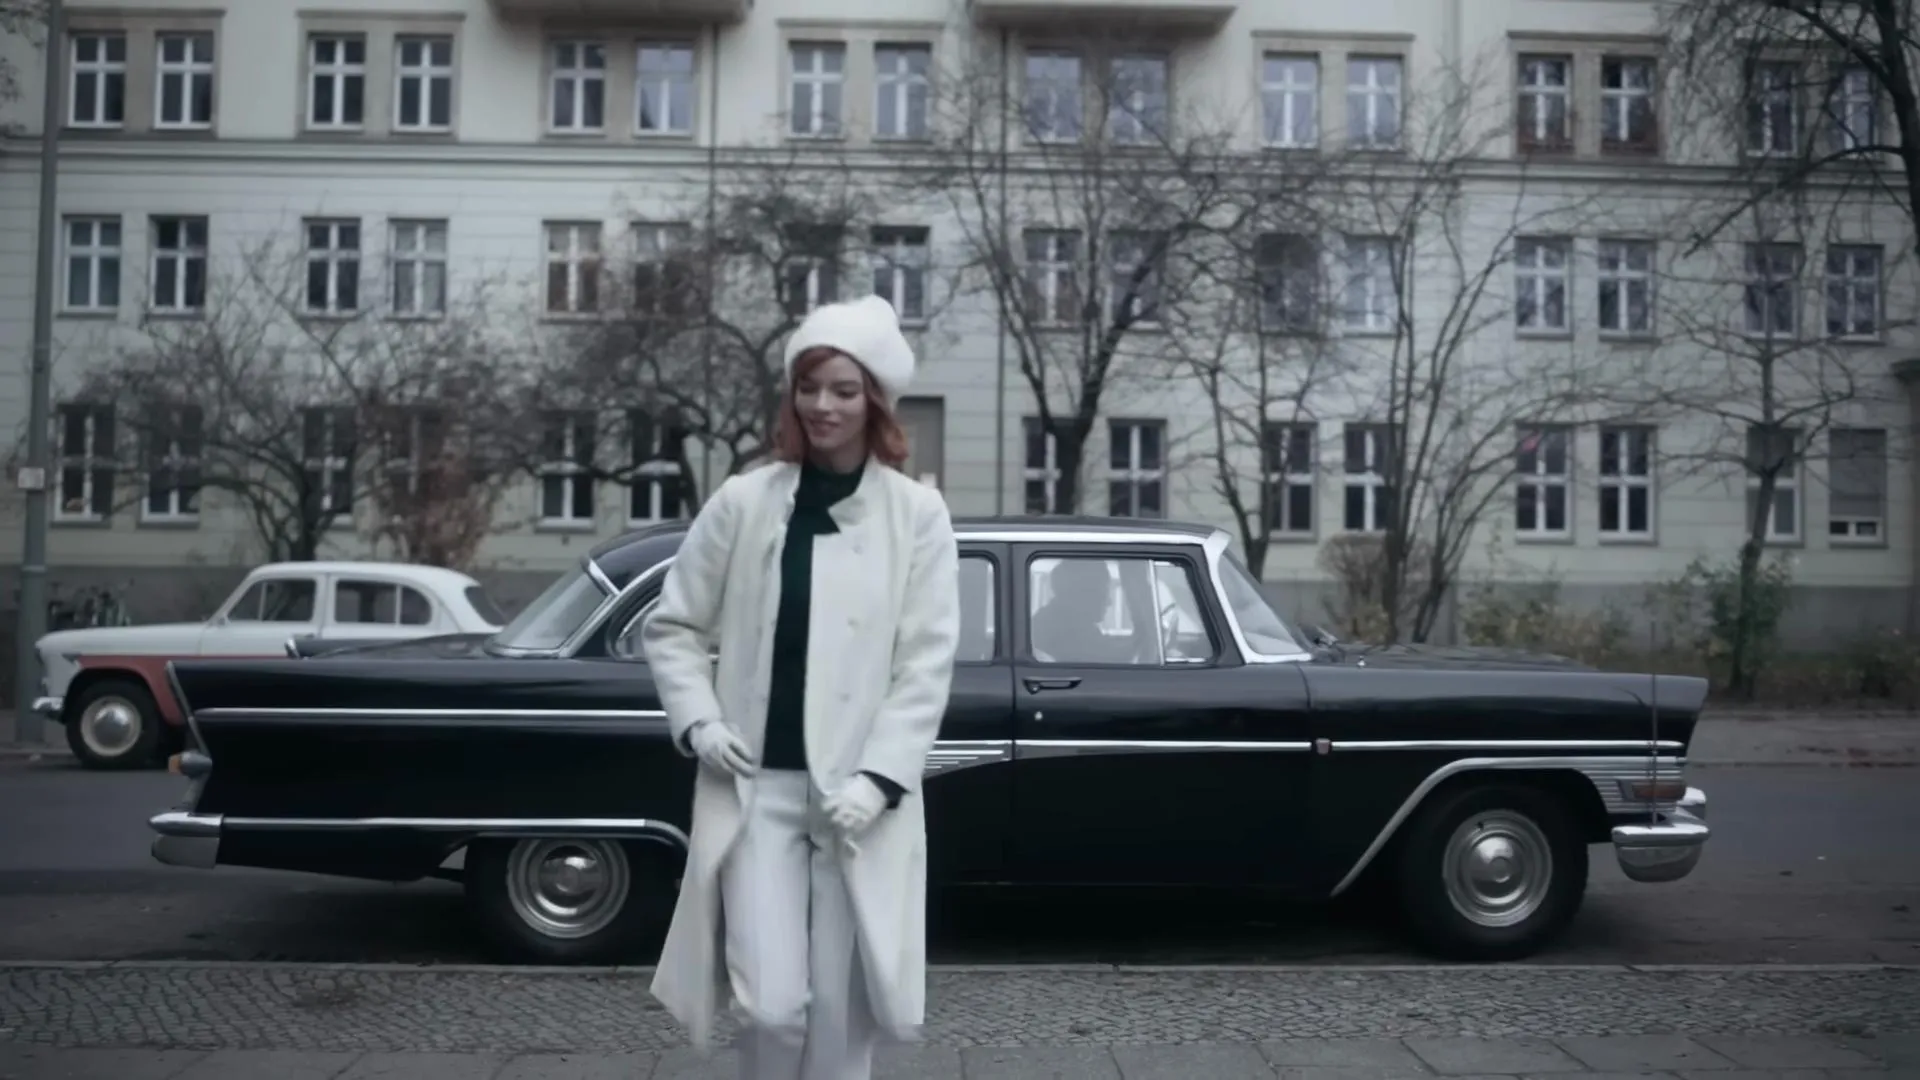
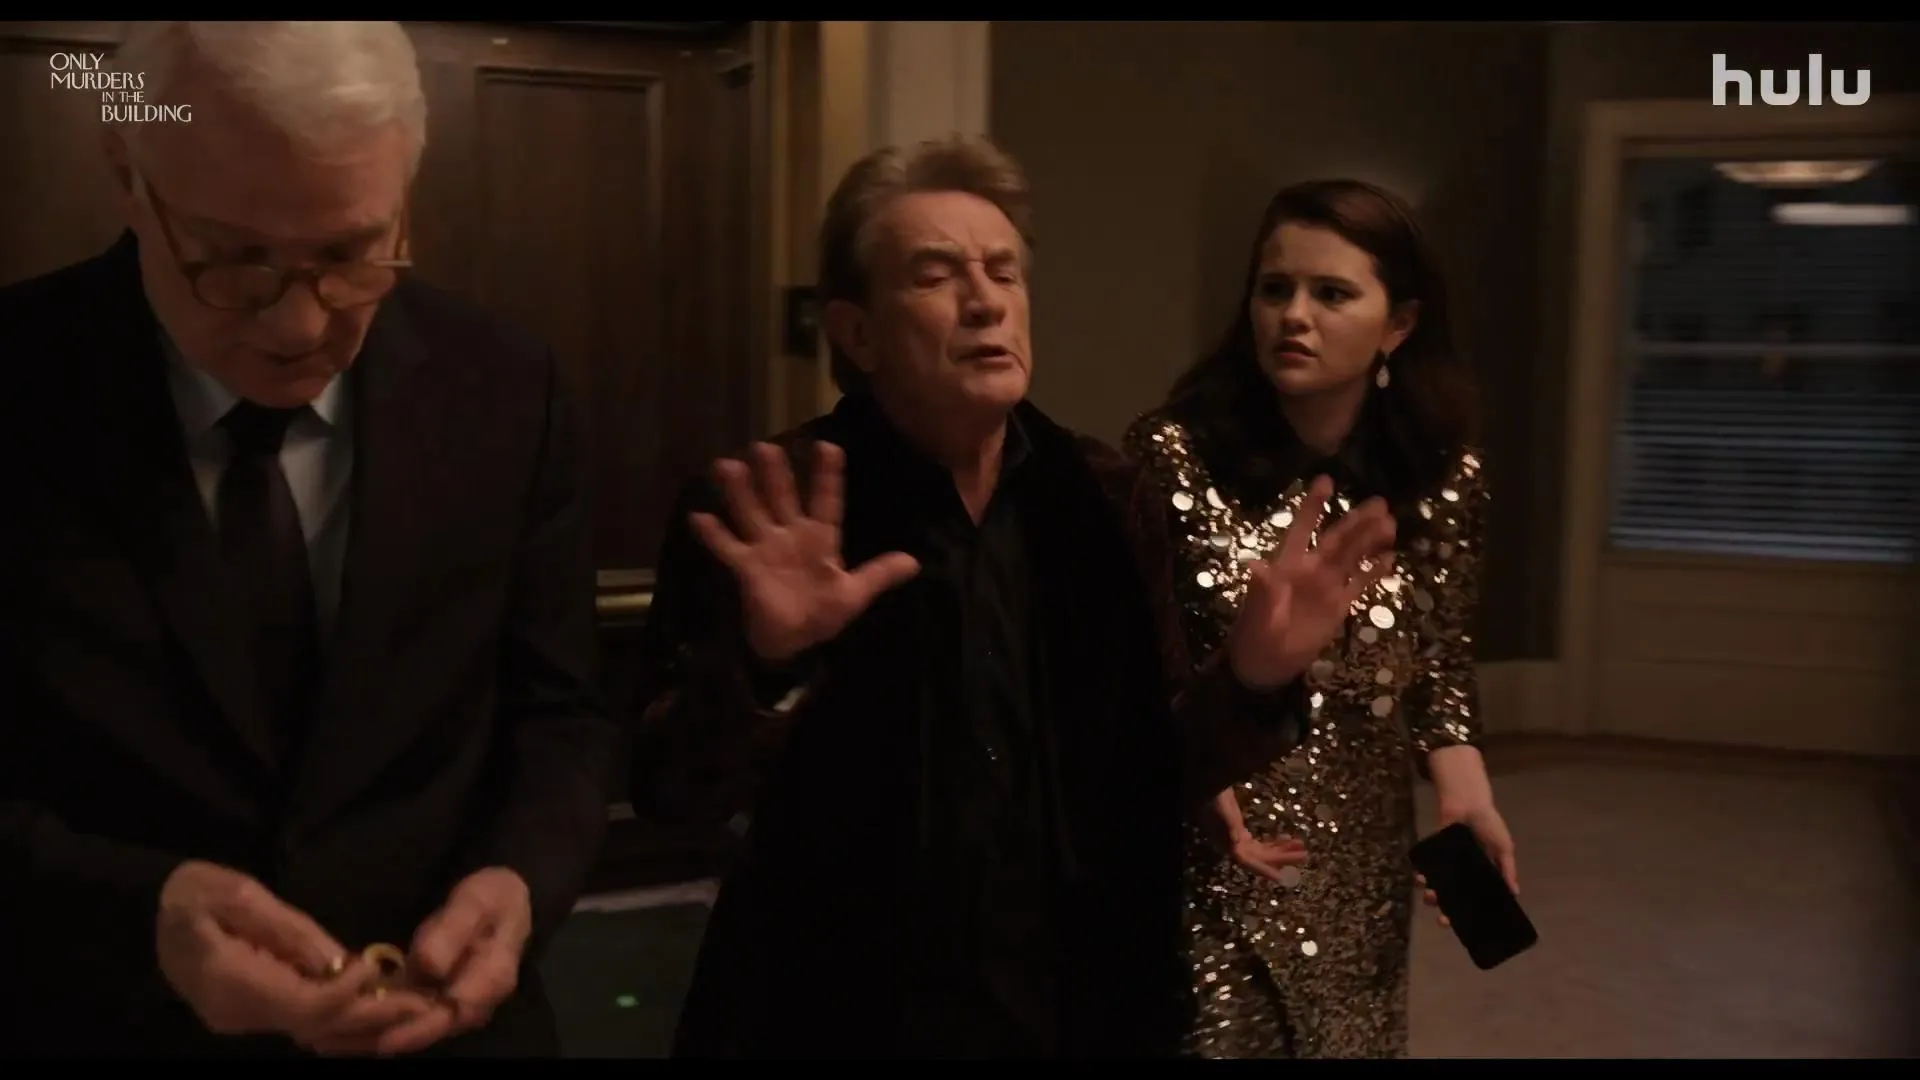
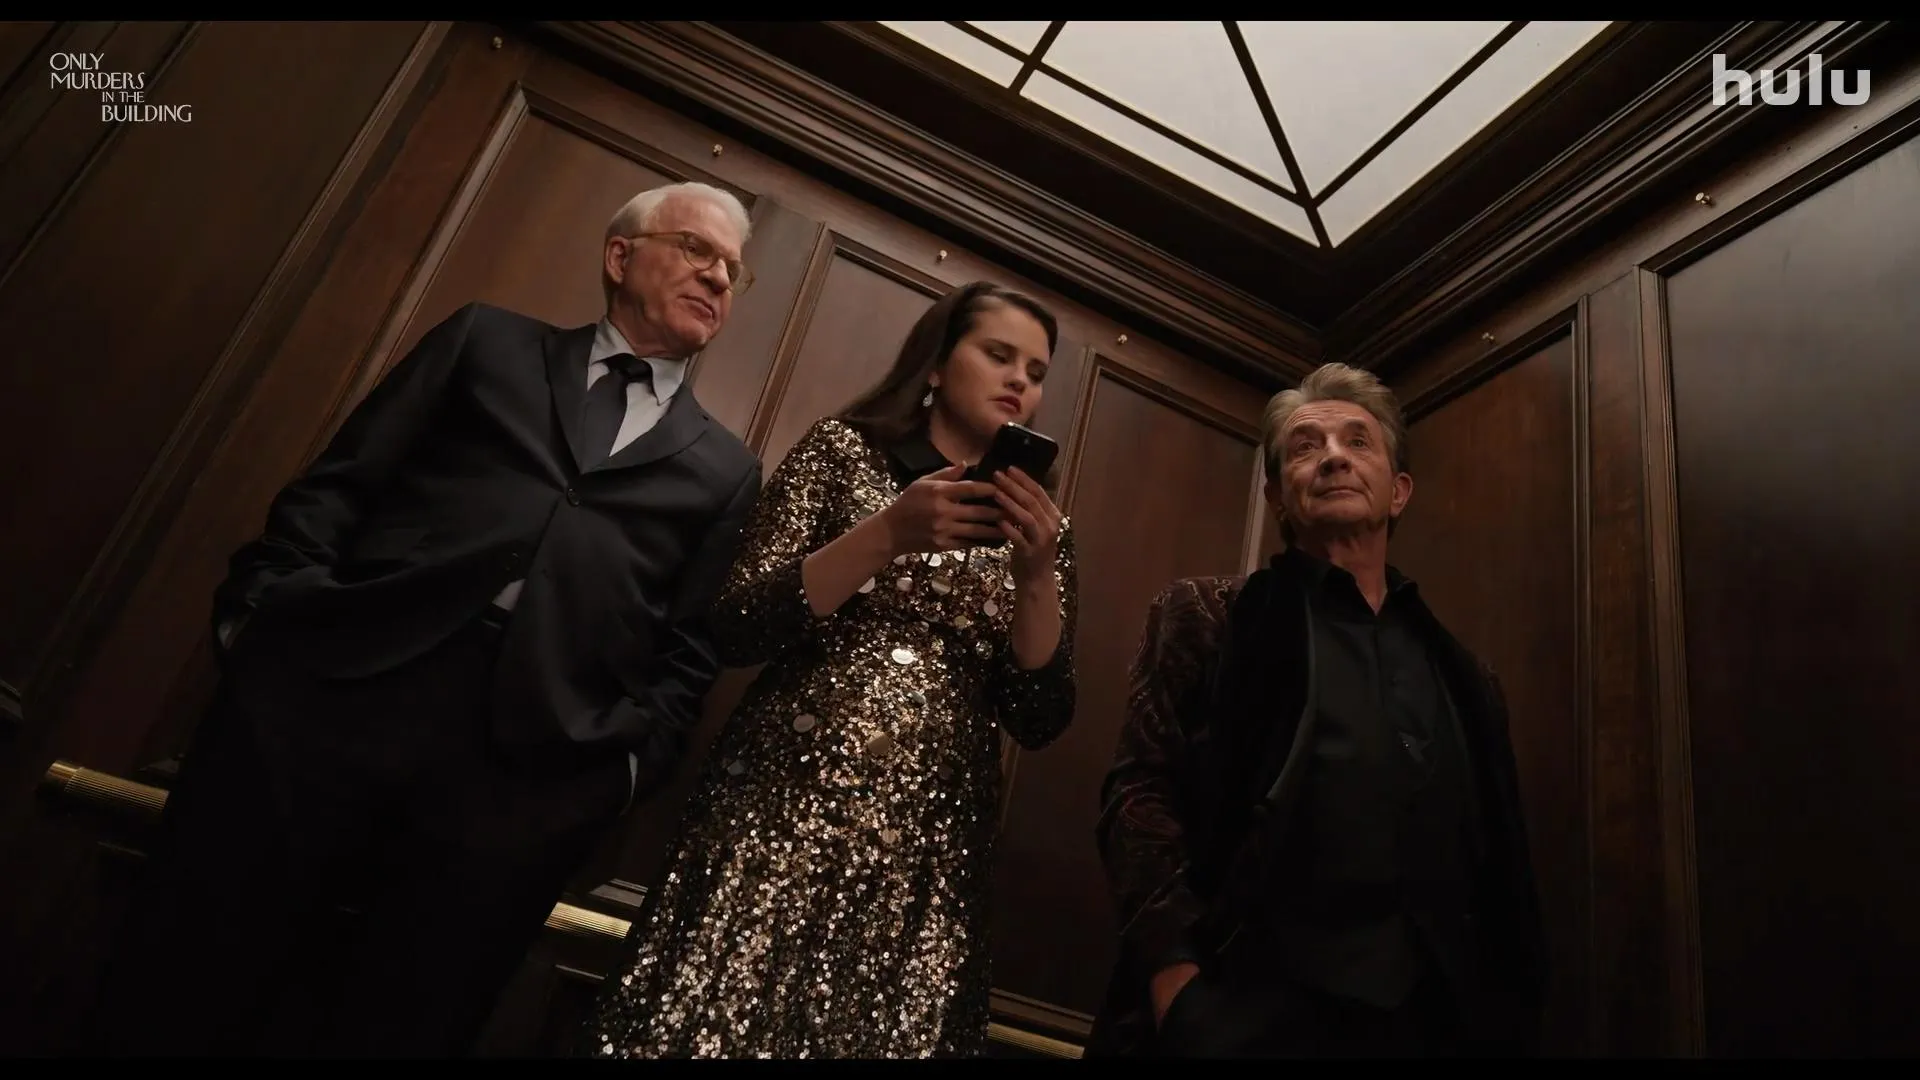

In [36]:
scene_view.select(scene_view.beginning_frame, scene_view.scene_prompt).limit(3).collect()

Now we have a `scene_prompt` column that contains the generated text descriptions. This prompt will be reused for both image and video generation in the next sections.

Let's look at our table history again:

In [37]:
scene_view.history()

,version,created_at,user,change_type,inserts,updates,deletes,errors,schema_change
0,67,2026-01-28 01:41:17.263241+00:00,None,schema,0,18,0,0,Added: scene_prompt
1,66,2026-01-28 01:41:11.477612+00:00,None,schema,0,18,0,0,Added: prompt_response
2,65,2026-01-28 01:41:11.470502+00:00,None,schema,0,18,0,0,Deleted: prompt_response
3,64,2026-01-28 01:39:04.470221+00:00,None,schema,0,18,0,0,Added: prompt_response
4,63,2026-01-28 01:39:04.457690+00:00,None,schema,0,18,0,0,Deleted: prompt_response
...,...,...,...,...,...,...,...,...,...
63,4,2026-01-26 21:52:40.933282+00:00,None,schema,0,10,0,0,Added: transcript_lang
64,3,2026-01-26 21:52:40.904737+00:00,None,schema,0,10,0,0,Added: transcript_text
65,2,2026-01-26 21:52:02.790064+00:00,None,schema,0,10,0,0,Added: transcription
66,1,2026-01-26 21:51:58.505301+00:00,None,schema,0,10,0,0,Added: audio


## 04 - Generate Scene Images

Now let's put these prompts from `gemini-2.0-flash` to the test. We will use these scene prompts to generate visual images, using `imagen-4.0-generate-001` as our text-to-image model.

The examples below use `.select().where()` to test generation on a single scene. This is a **query** - it runs once and returns results without storing anything. This is perfect for testing expensive operations before applying them to all rows. Later, you'll see how to add image generation as a **computed column** to process all scenes automatically and store the results persistently.

Some things to note as you consider these options:

1. All frames are resized from 1920x1080 to 640x360 before being sent to Gemini. Gemini's API limit for combined text and image data is 100MB per request (recently increased from 20MB). We resize to stay well under this limit.

1. In Pixeltable, you can chain image operations like [`.resize()`](https://docs.pixeltable.com/sdk/latest/image#udf-resize) directly on image columns - you don't need to save the resized image to disk or create a separate column to include it in your API call.

1. Many model providers, including Gemini, limit how many requests you can send per minute (RPM = requests per minute), per day (RPD = requests per day), or both (these also may vary by model, too). Pixeltable gives you a few options for working within those rate limits:
    - First, do nothing! Pixeltable defaults to 600 requests per minute, but dynamically listens to model return messages to walk that pace back. For example, Google will tell you at some point to wait for 50+ seconds before submitting another API request. Pixeltable listens to these messages from Google and schedules requests appropriately.
    - Second, you can set rate limits globally across all your Pixeltable projects with a `~./pixeltable/config.toml` per provider and per model. This is a good option if you want to "cap" Pixeltable's API request pace based on known rate limits or budget constraints.
    - Third, you can set rate limits as environment variables. This is a good option for either overriding your global settings from your `config.toml` file, or just to cap the Pixeltable request pace in a specific notebook or Python session.

In [ ]:
# Uncomment to set rate limits in your Python session
#os.environ['GEMINI_RATE_LIMITS'] = '{"gemini-2.0-flash-exp": 10}'
#os.environ['IMAGEN_RATE_LIMITS'] = '{"imagen-4.0-generate-001": 10}'
#os.environ['VEO_RATE_LIMITS'] = '{"veo-3.1-generate-preview": 2}'

Here, we are creating a variable `scene_image` to hold the result of the query. This is an in memory result and does not change your stored table. It is also limited: you can pull this result back up within your Python session only. We'll persist outputs in the next section.

In [48]:
scene_image = scene_view.where(scene_view.pos == 7).select(
    scene_view.pos,
    scene_view.scene_prompt,
    scene_image=pxtf.gemini.generate_images(
        prompt=scene_view.scene_prompt,
        model='imagen-4.0-fast-generate-001'
    )
).collect()

pos,scene_prompt,scene_image
7,"An intricate miniature diorama of a hallway scene from ""Only Murders in the Building,"" featuring miniature versions of Charles, Oliver, and Mabel. Charles examines a tiny cork in his hands, sculpted from clay, wearing a felt suit. Oliver, in a hand-stitched velvet coat, throws his hands up in exasperation, while Mabel, dressed in a sequined felt dress, looks on anxiously, a minuscule cell phone clutched in her hand. The hallway is constructed from painted wood, with tiny, imperfect details like uneven baseboards and miniature textured wallpaper. Close-up shot, photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. The lighting is dramatic, a single miniature LED spotlight mimicking overhead lighting, casting long, exaggerated shadows. Color palette is muted beige, brown, and gold, with pops of the dark velvet and sequins. The mood is tense and slightly comedic, with a hint of mystery.",
7,"An intricate miniature diorama of a Berlin street scene from ""The Queen's Gambit,"" depicting a smiling elderly man in a dark coat and hat offering a handshake, a small chessboard visible on a table in the background, faded Soviet-era architecture behind, photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Medium shot. Cold, diffused lighting, casting long miniature shadows and highlighting the textures of tiny, handcrafted felt and clay figures, miniature wood cobblestones, a chess set made of tiny painted beads. Predominantly gray, brown, and muted red color palette. Melancholy, hopeful mood.",

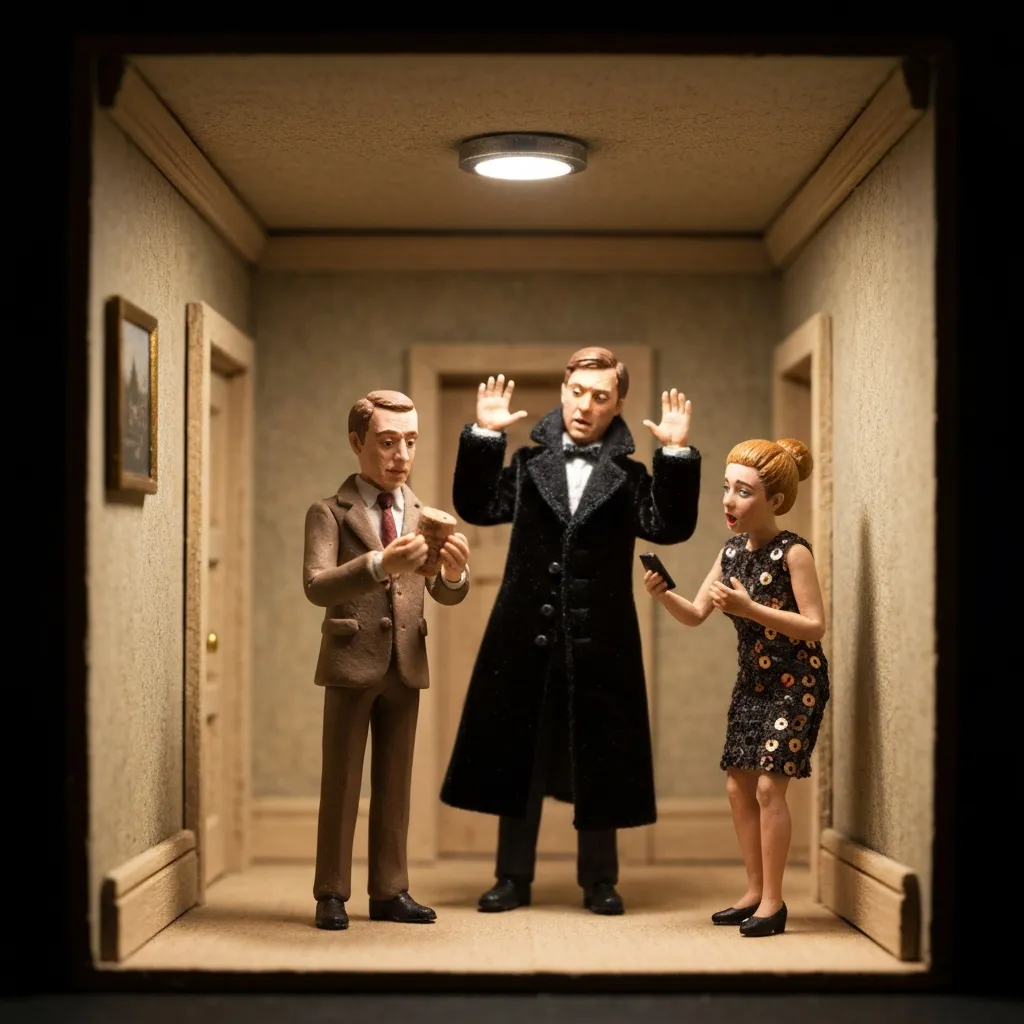
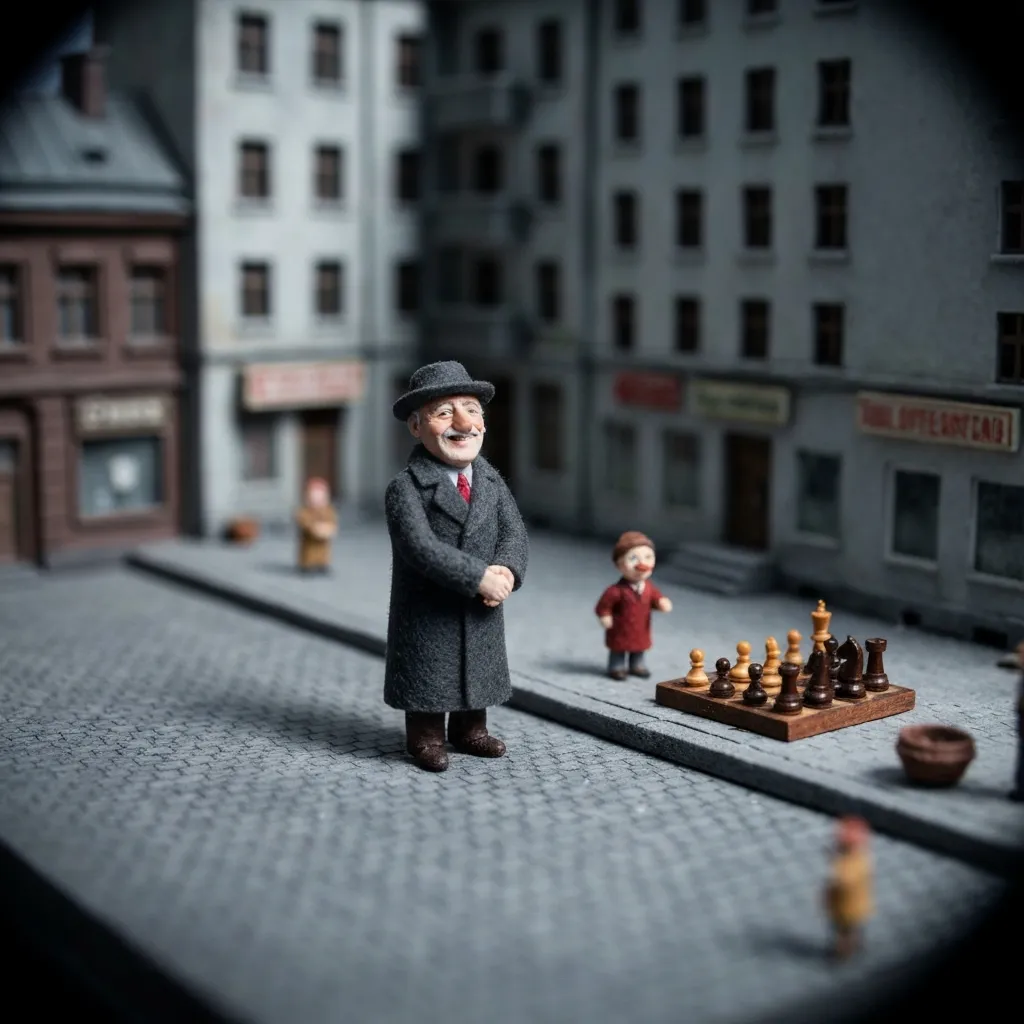

In [49]:
scene_image

You've tested image and video generation on individual scenes in queries using `.select().where()`. 

But what if you want to generate images for **all** scenes automatically, and save them persistently in your scene view?

## 05 - Generate Across All Scenes

You've tested image generation on a single scene using `.select().where()`. Now you'll add it as a computed column to process all scenes automatically.

**What changes when you use a computed column:**

1. **Processes all rows**: Generates images for all rows (here, we have 1 row per scene for each video) with a unique prompt per row, without loops or iteration code
2. **Parallel execution**: Pixeltable parallelizes API calls automatically - faster than sequential processing
3. **Persistent storage**: Results are stored in the table, not just returned as query results
4. **Incremental updates**: If you add new videos to the base table, the scene detection and image generation cascade automatically

Here we will generate just images with the `imagen-4.0-generate-001` model. At the time of this workshop, Gemini limits this model to 10 requests per minute with a max of 70 images per day, so you can run this code on all rows within the free tier.

If you want to test out video generation and have your billing setup, you can adapt our query code above to use computed columns instead. You'll want to configure Pixeltable with provider-specific rate limits: https://docs.pixeltable.com/platform/configuration#rate-limit-configuration

This computed column will automatically generate trailer images for all scenes - it takes about 2 minutes to execute.

In [50]:
scene_view.add_computed_column(
    scene_image=pxtf.gemini.generate_images(
        prompt=scene_view.scene_prompt,
        model='imagen-4.0-fast-generate-001'
    ),
    if_exists='replace',
    on_error='ignore' # Continue processing despite individual row-wise failures
)

Added 18 column values with 1 error in 42.62 s (0.42 rows/s)


18 rows updated, 1 exception.

**What happens when you execute this code:**

We've created a **declarative workflow** with three computed columns that form a processing pipeline:

1. `beginning_frame` - Extracts a frame from each video segment
2. `trailer_prompt` - Generates a text description from the frame (multimodal AI)
3. `trailer_image` - Generates an image from the text description (text-to-image AI)

Each computed column builds on the previous one. Pixeltable handles the orchestration - it knows the dependencies and executes them in the correct order automatically.

Let's take a look at our collection of generated images:

pos,scene_prompt,scene_image
0,"An intricate miniature diorama of Mabel, Charles, and Oliver huddled together in Mabel’s meticulously detailed, cluttered apartment, surrounded by crime scene evidence like miniature police tape, photographs, and maps, photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Medium shot; dramatic miniature lighting with a single, intense, off-center spotlight illuminating the trio, casting long, exaggerated shadows; tiny handcrafted details like miniature yarn fibers clinging to Mabel's sweater, the worn texture of the miniature Persian rug, and the minute details of the suspect board; materials of felt, clay, and wood; the color palette is muted, with browns, grays, and reds dominating, punctuated by the bright blue of the police tape and the crimson of a spilled miniature bottle of red wine; the mood is suspenseful, focused, and tinged with dark humor.",
1,"An intricate miniature diorama of a young boy on a bicycle near a house, photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Medium shot, dramatic miniature lighting with a single light source casting long shadows, tiny handcrafted details like individual bricks made of clay and miniature plants made of felt, the bicycle built with thin wire and wood. Color palette of faded yellows, muted greens, and reddish-brown bricks. The mood is nostalgic and slightly melancholic.",
2,"An intricate miniature diorama of a terrified young girl in a plain room, her face covered in dark makeup, gripping a large landline telephone receiver, her mouth open in a silent scream. Photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. Close-up shot, dramatic side lighting mimicking low-quality home video footage, tiny handcrafted details of felt hair, clay skin texture, a miniature telephone with coiled cord made from wire, wood paneling background. Color palette of faded beige, pale blue, and dusty rose. Mood: eerie, vulnerable, and disturbingly childlike.",None
3,"An intricate miniature diorama of a young boy sitting in a blue backyard pool filled with cloudy water, bathed in dappled sunlight filtering through the trees, photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. A medium shot highlights the tiny, slightly blurred figure, handcrafted from clay and wearing a felt shirt. The miniature pool is constructed from wood and resin, with a rough, textured surface. The surrounding foliage is meticulously rendered from felt and wire. A single, focused miniature spotlight casts a soft, ethereal glow on the scene, highlighting the boy's face and the shimmering water. Color palette is muted blues, greens, and browns, evoking a nostalgic and slightly melancholic mood.",
4,"An intricate miniature diorama of Charles’ living room, cluttered and dimly lit, photographed with a tilt-shift lens creating selective focus and a dreamlike toy-world atmosphere. A medium shot with focus on a dark green velvet armchair piled with a black blazer, a striped vest slung over the back, and a miniature magazine featuring Ben Glenroy on the cover. To the right, a framed silhouette portrait hangs against dark wood shelves stacked with tiny books and a vintage lamp. An ornate floor ...... afted from felt, clay, and wood, with meticulous attention to detail on miniature props like a ceramic bowl with miniature faux cookies on the side table. Lighting is dramatic and concentrated, emulating the soft glow of the lamps, casting long shadows and highlighting the textures of the miniature objects. The color palette is dark and moody, with deep greens, browns, and blacks, punctuated by the warm light from the lamps. The overall mood is mysterious, nostalgic, and slightly whimsical.",
5,"An intricate miniature diorama of the elevator scene from ""Only Murders in the Building"", meticulously recreating the interior of an o
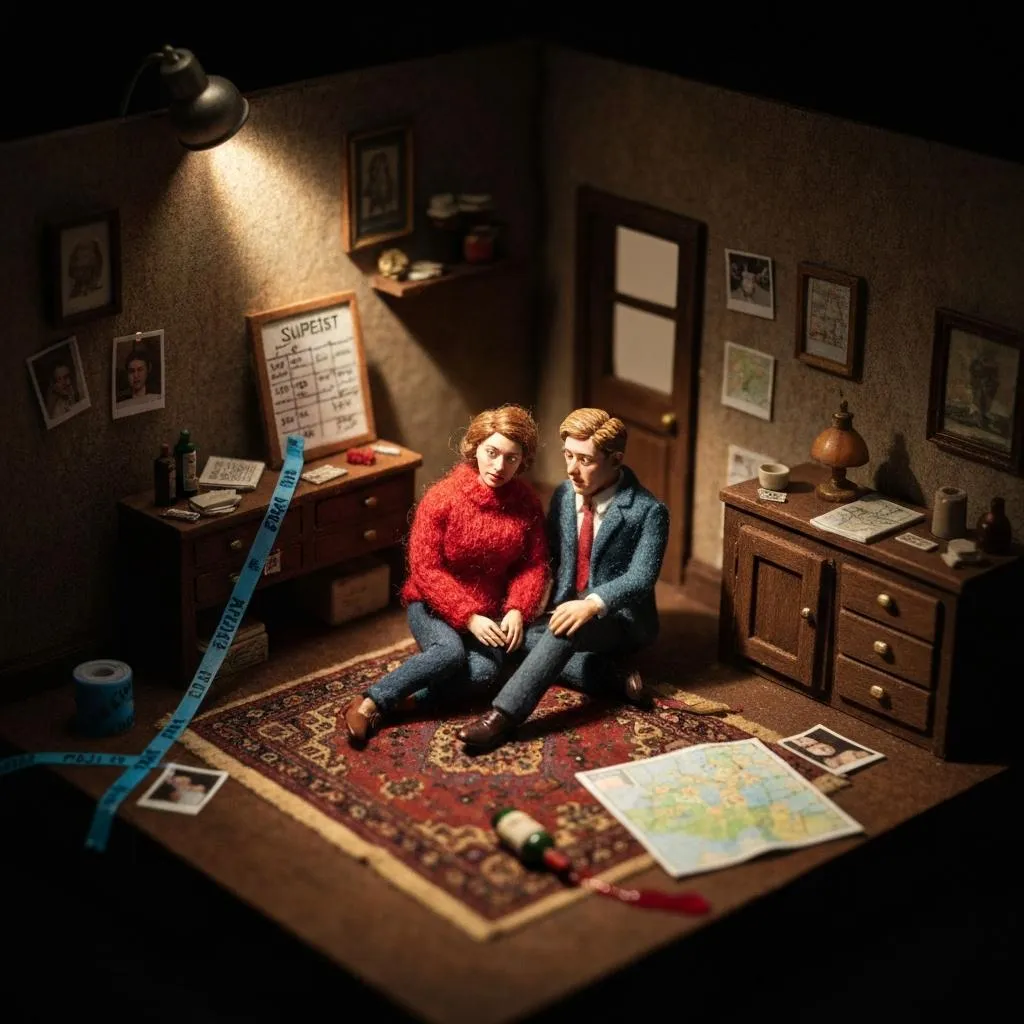
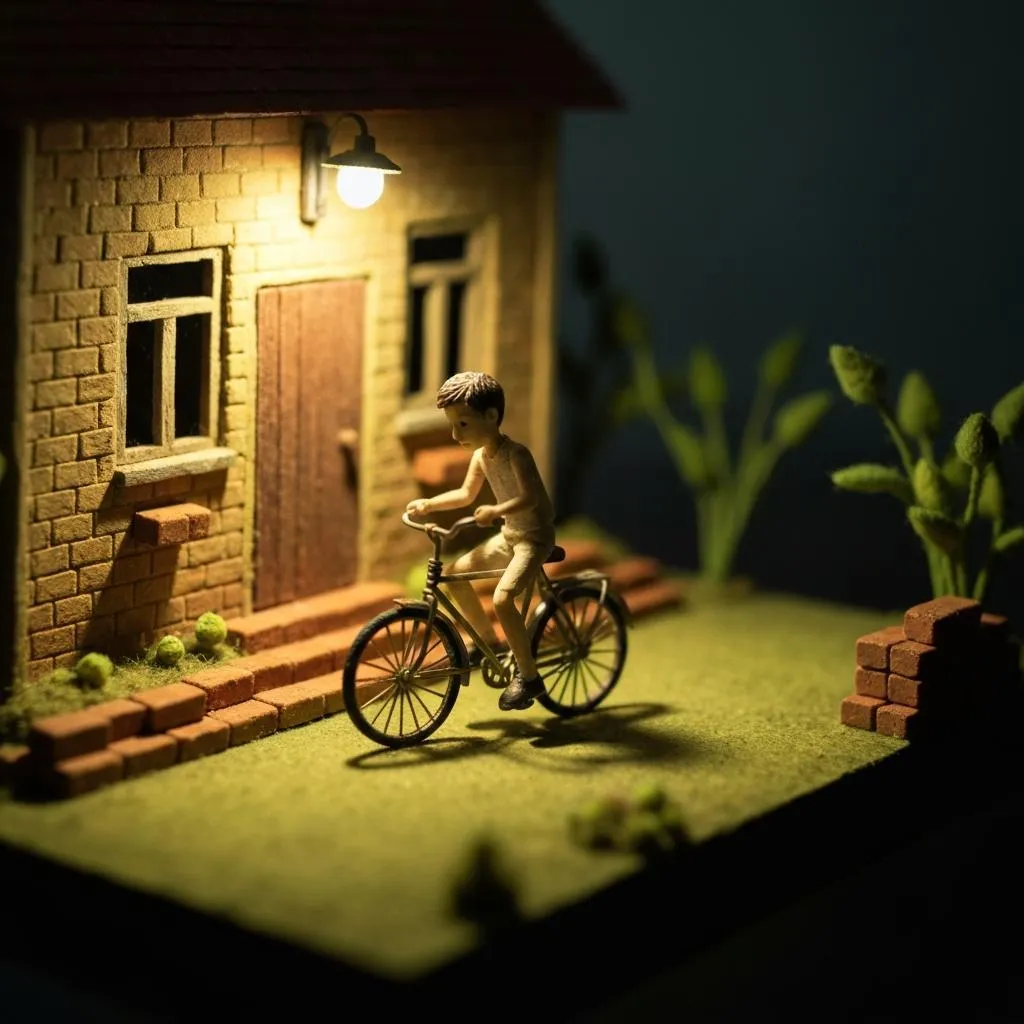
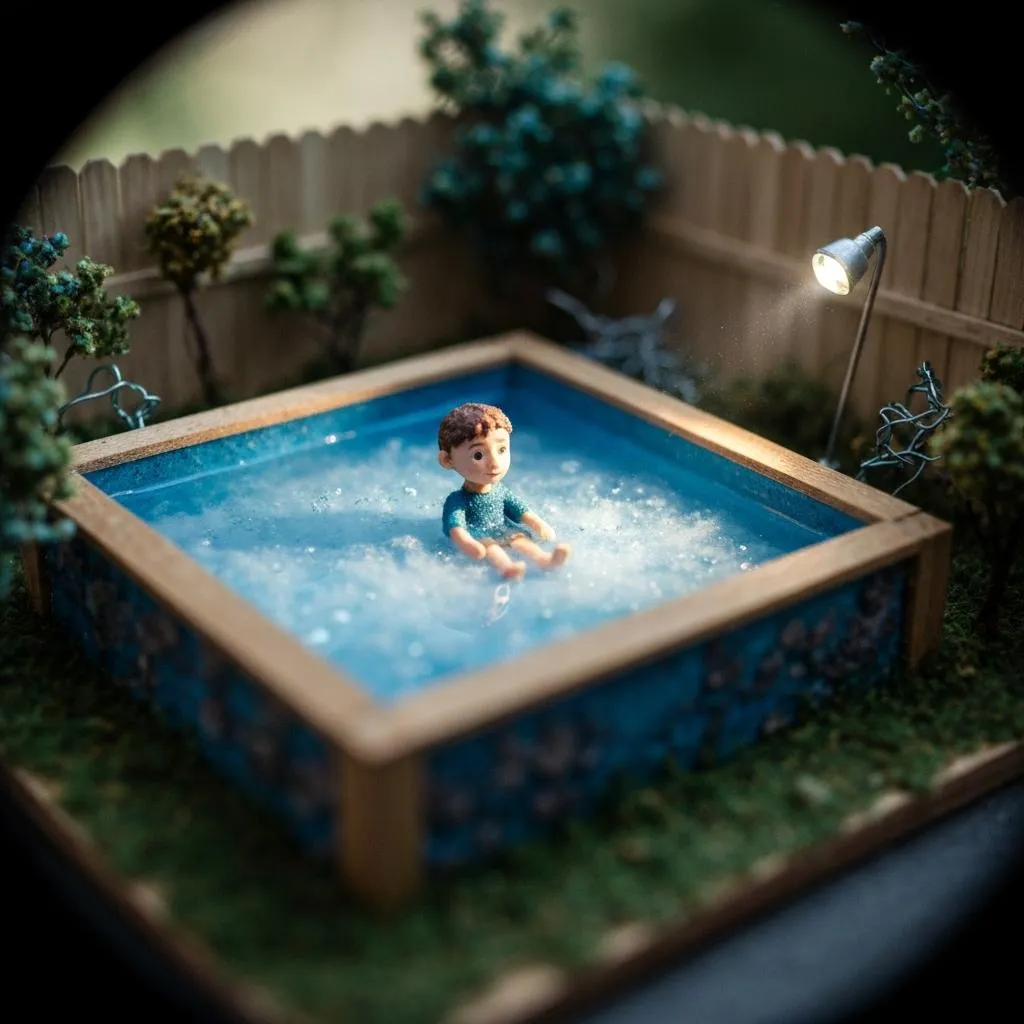
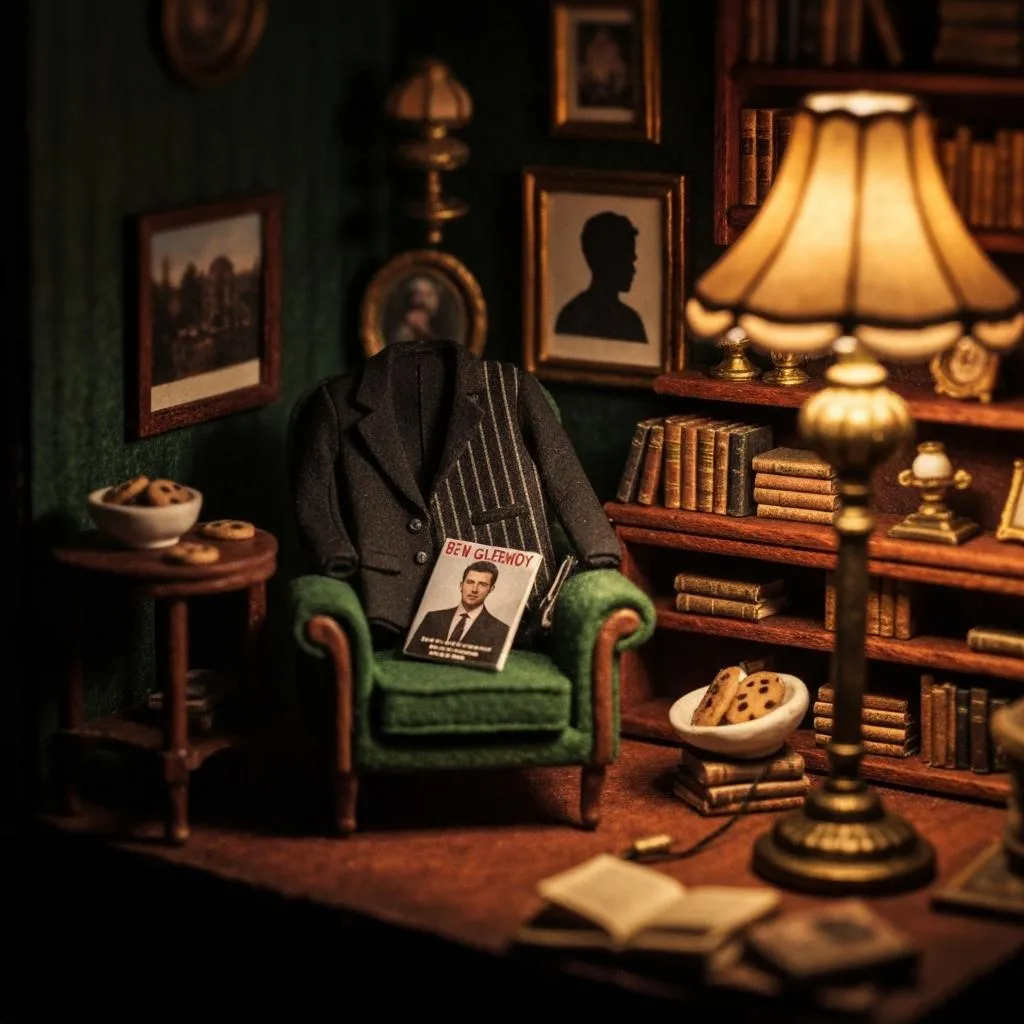
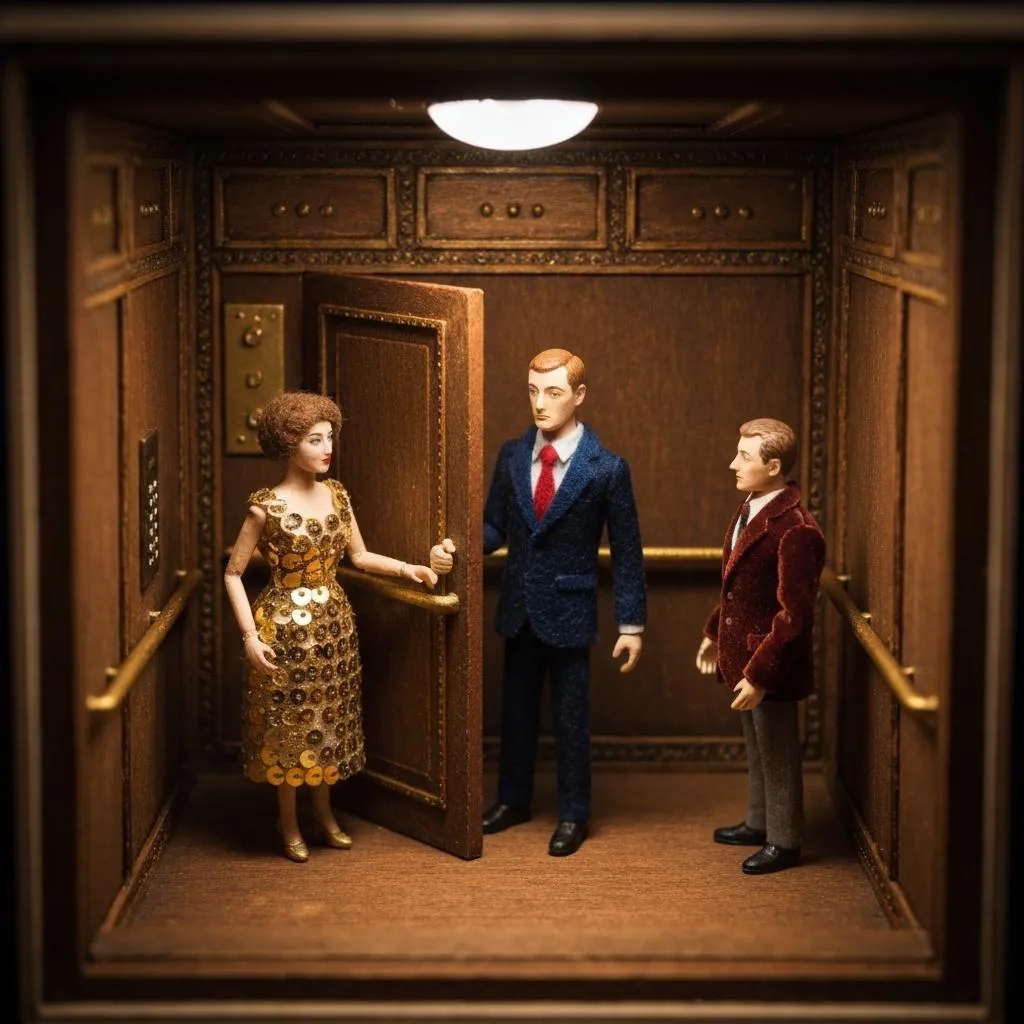
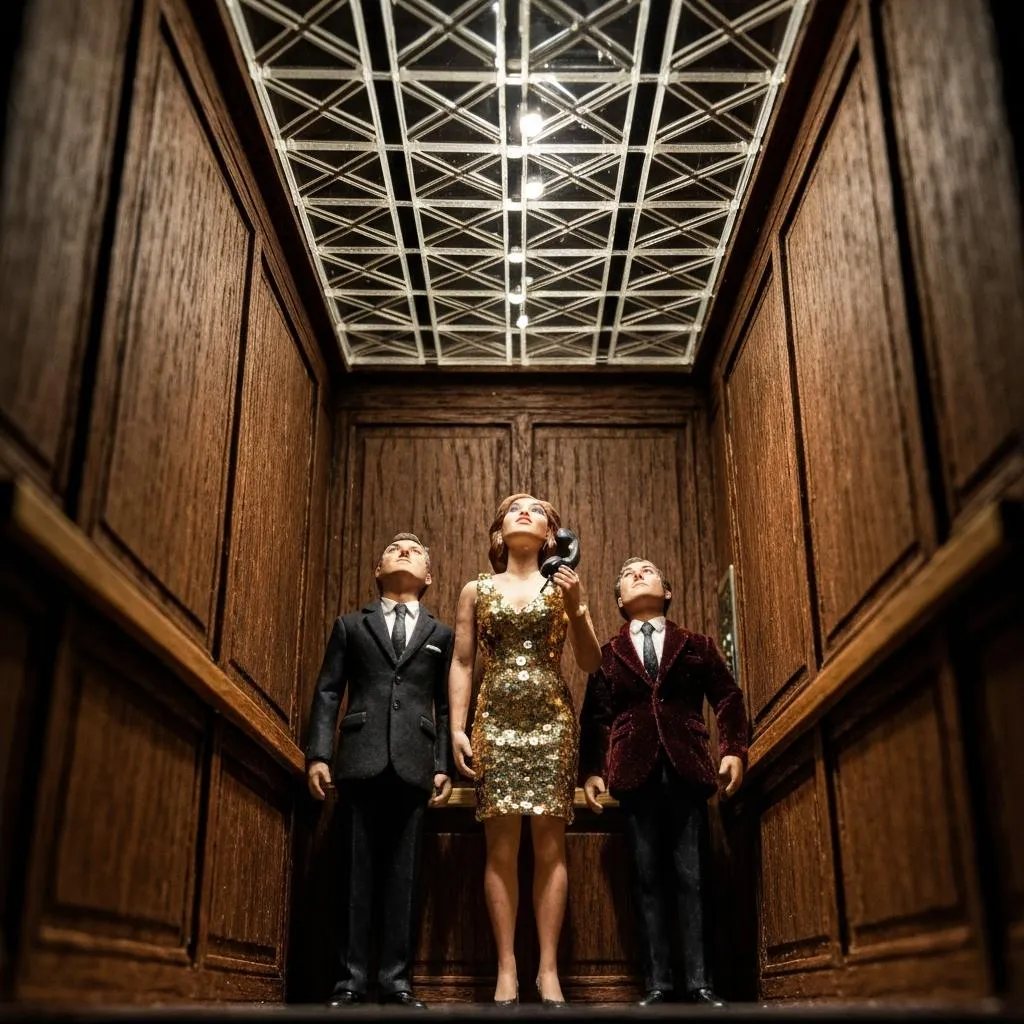
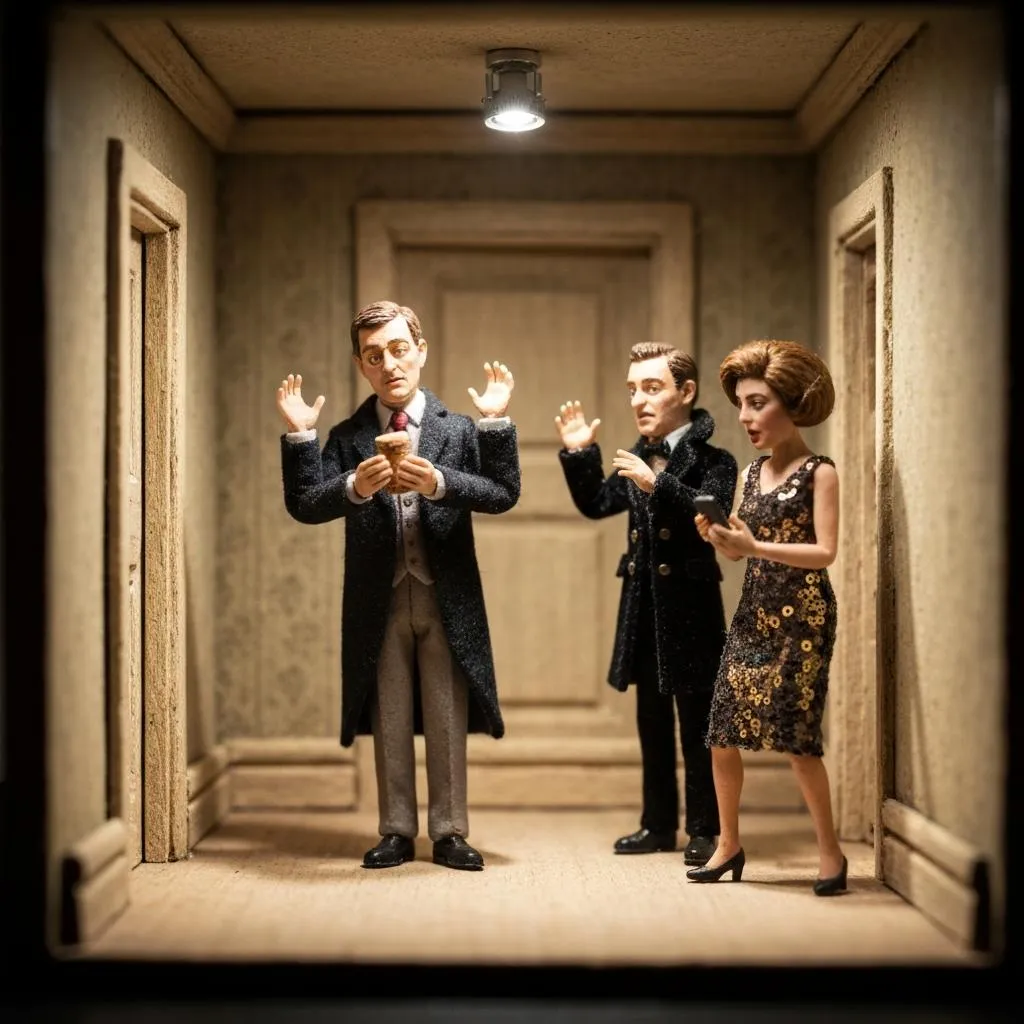
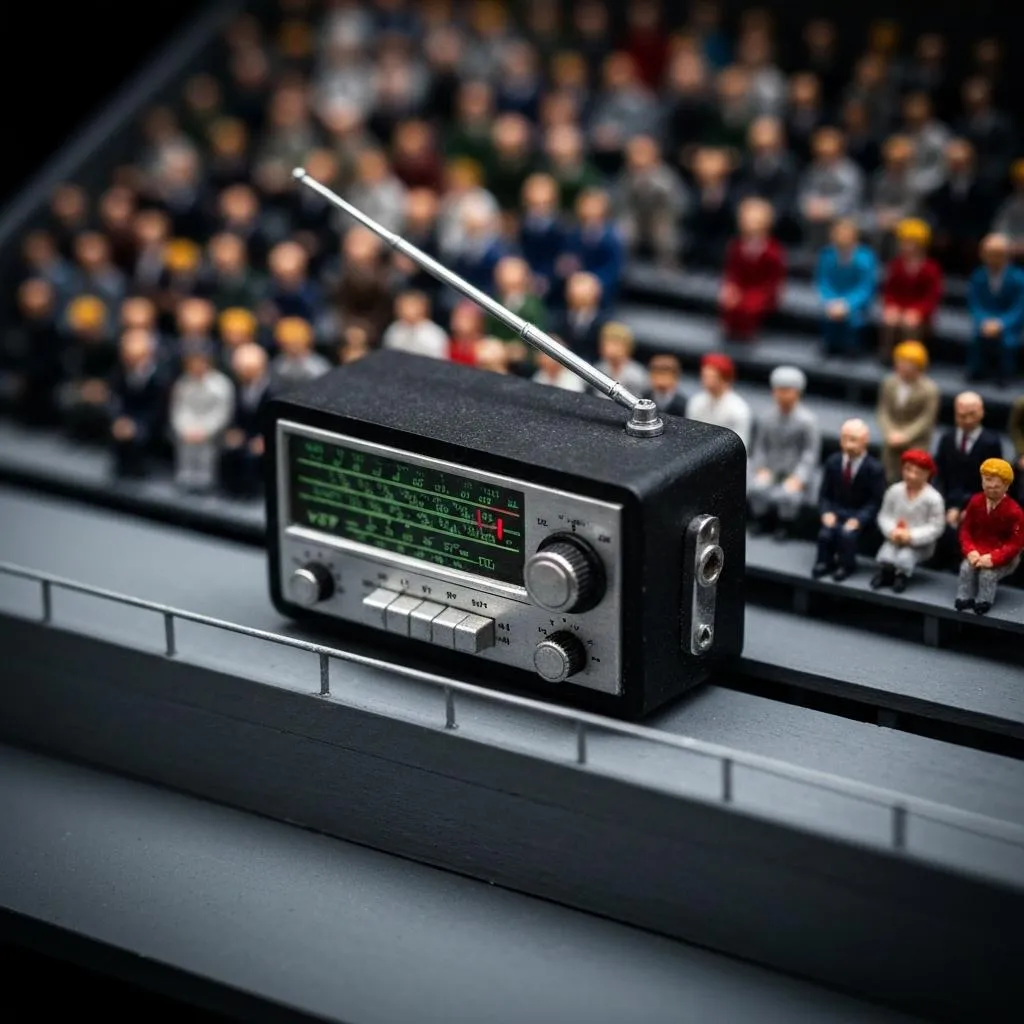
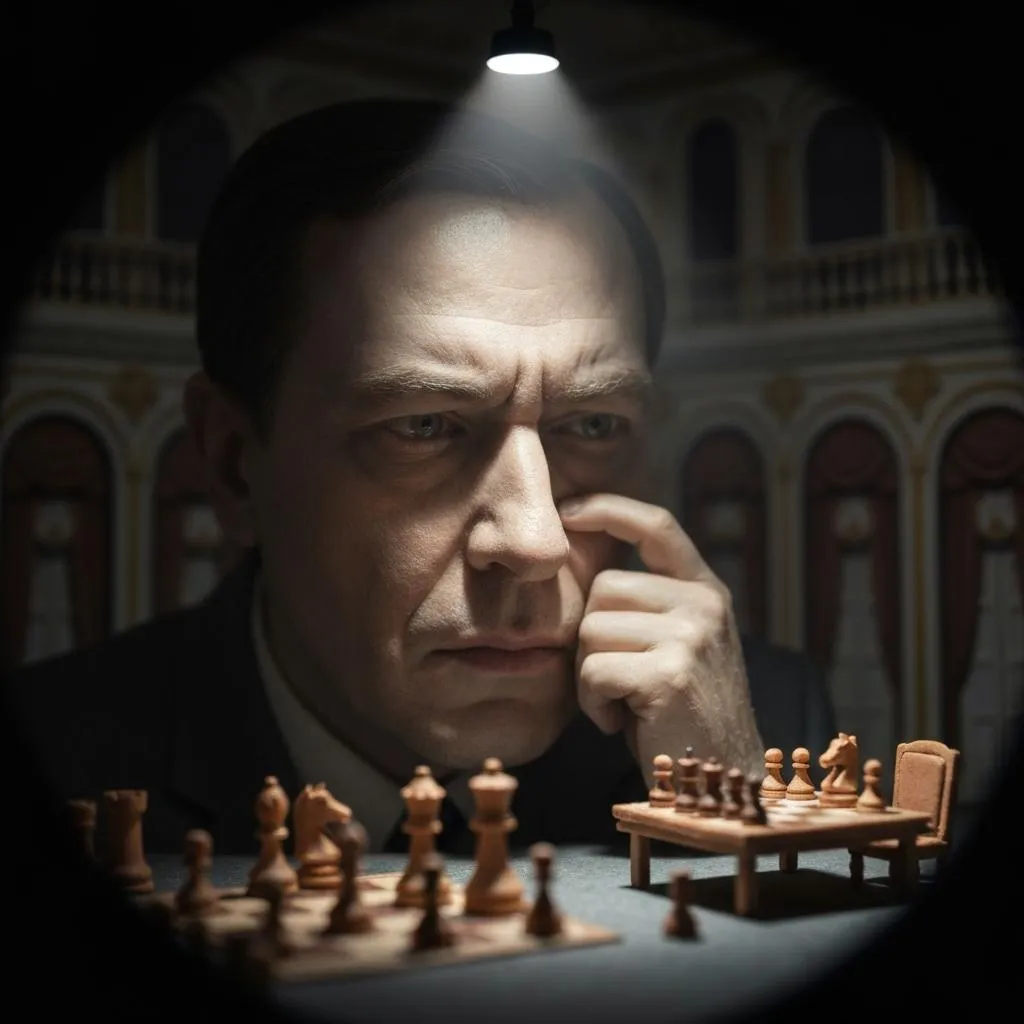
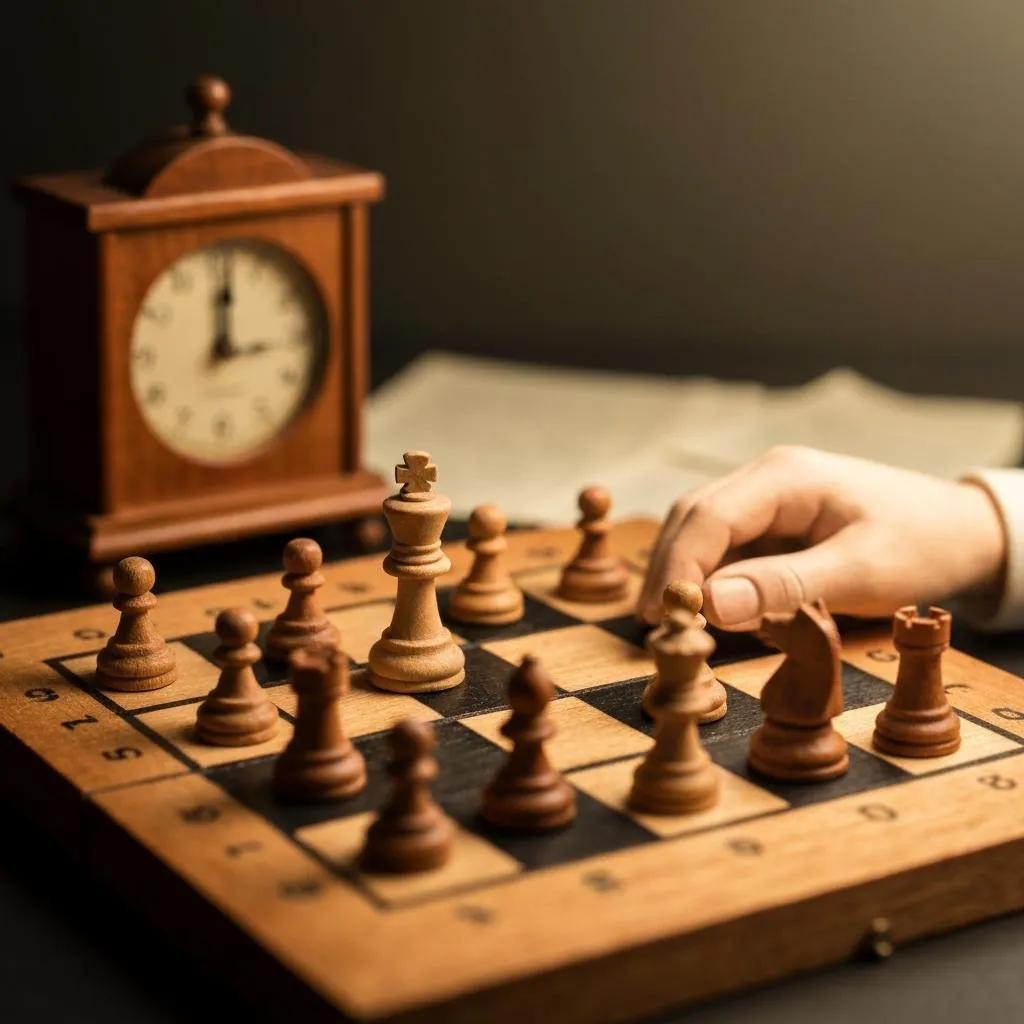
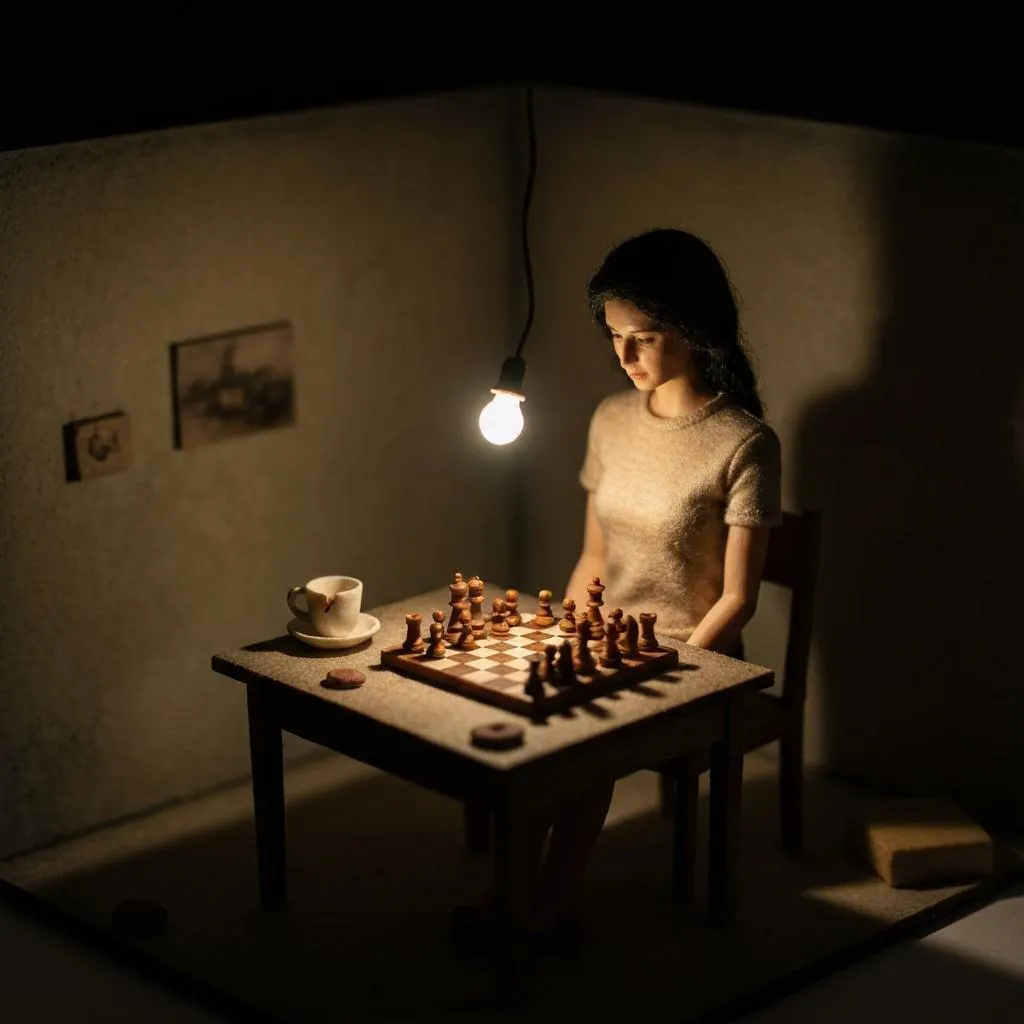
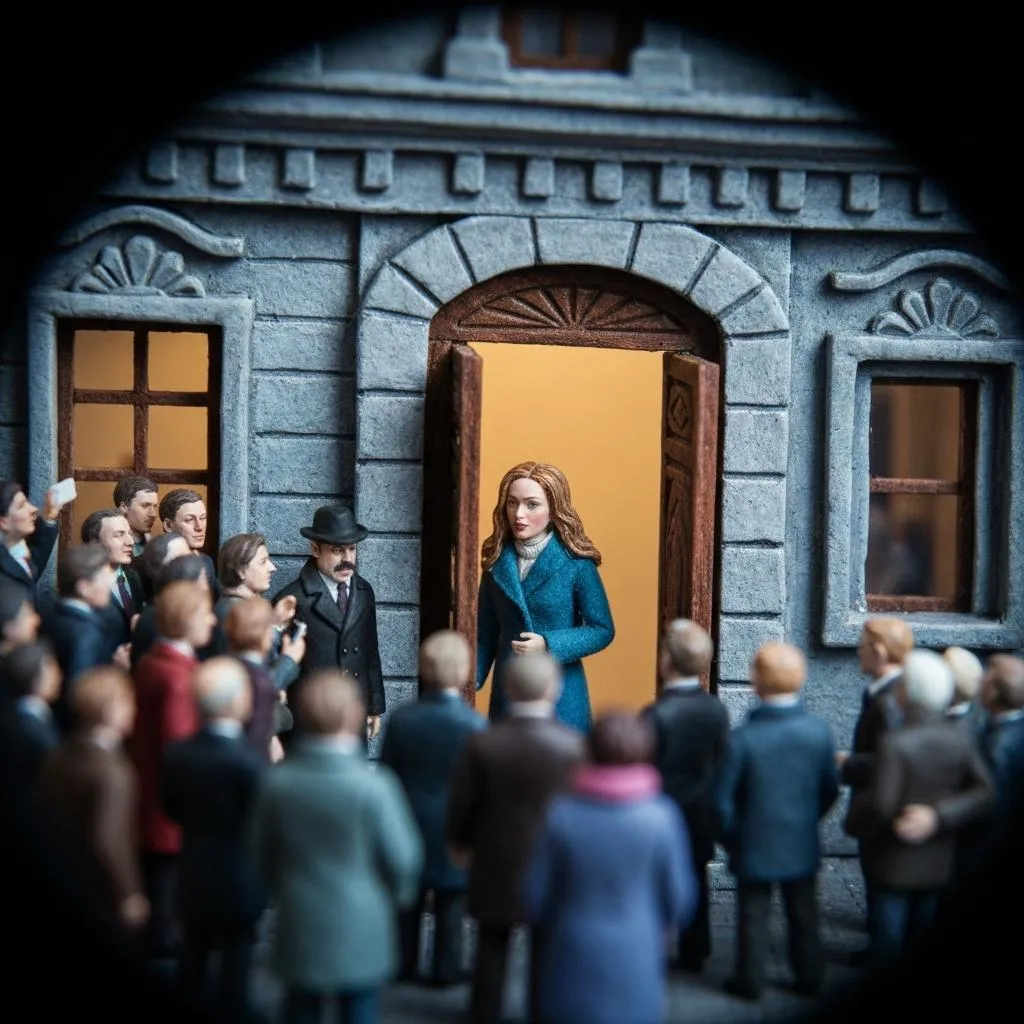
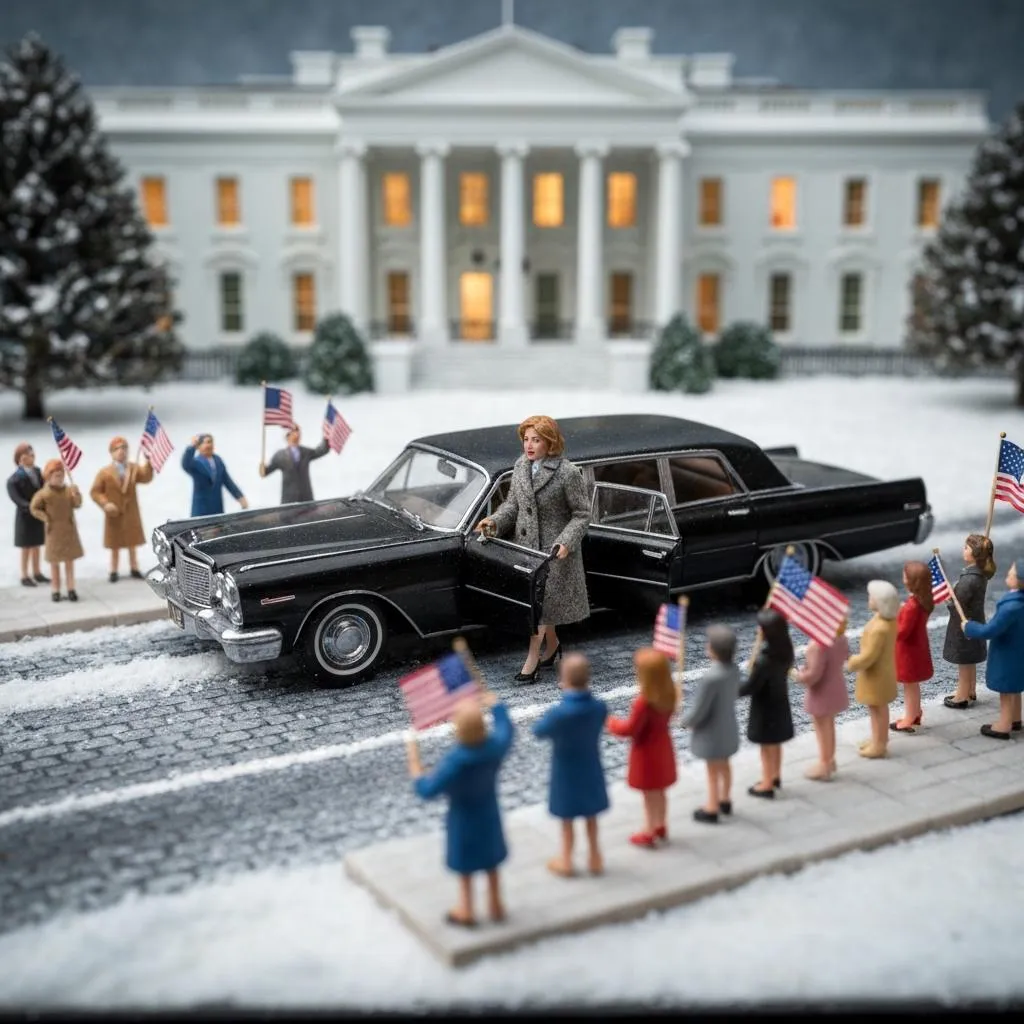
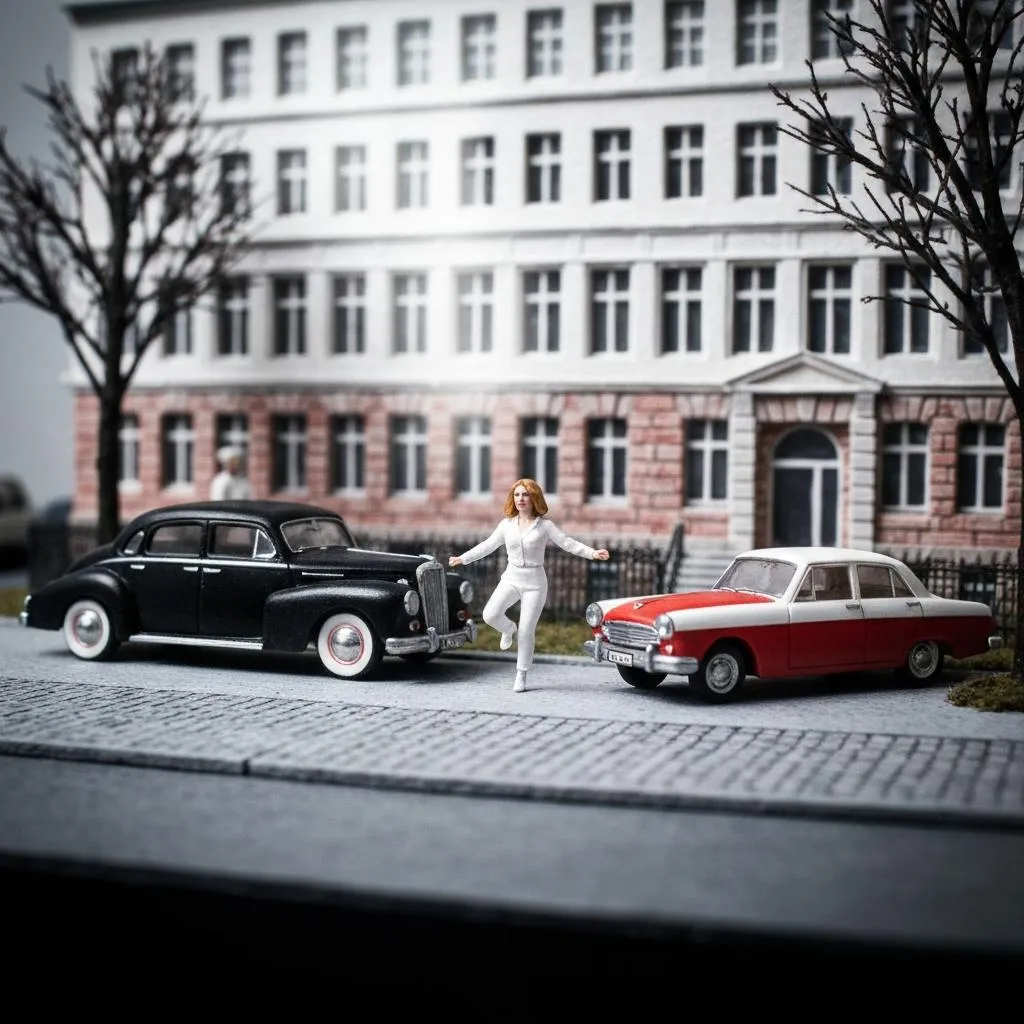
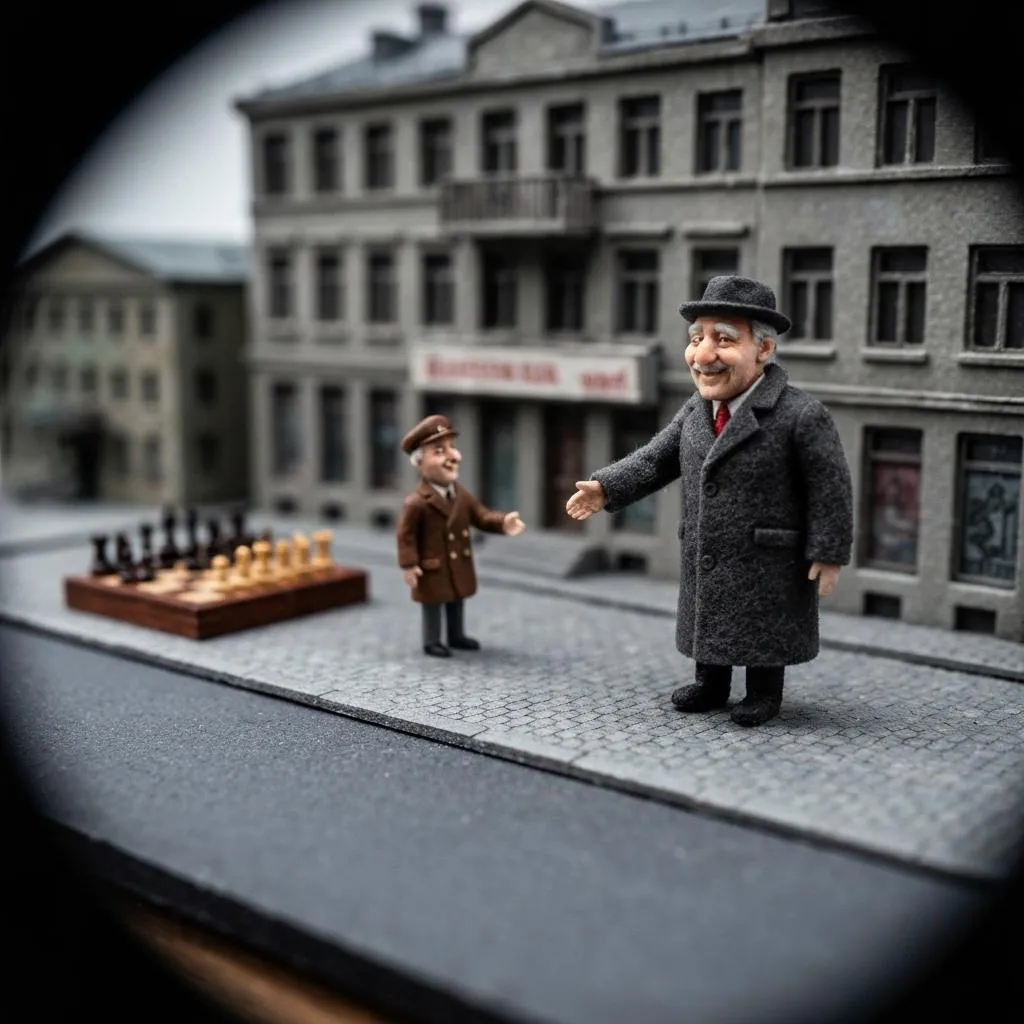
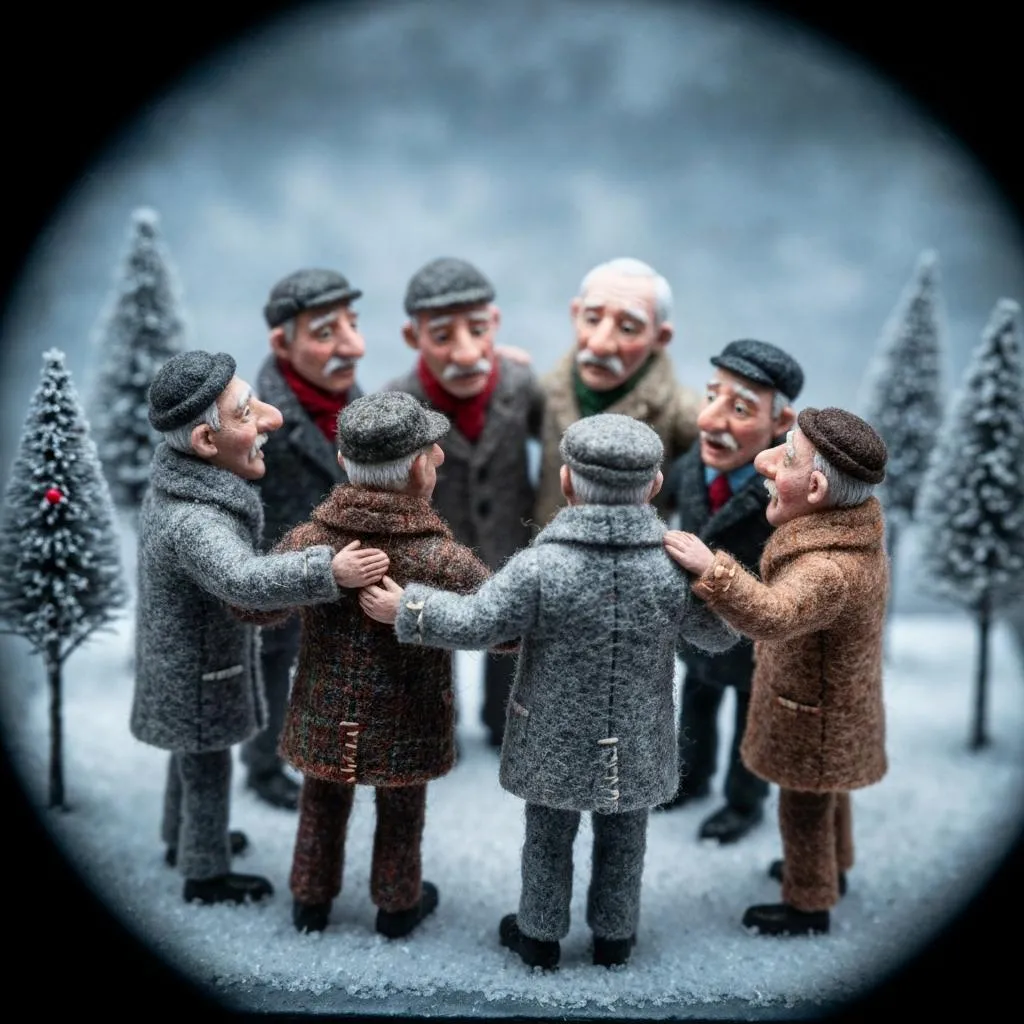
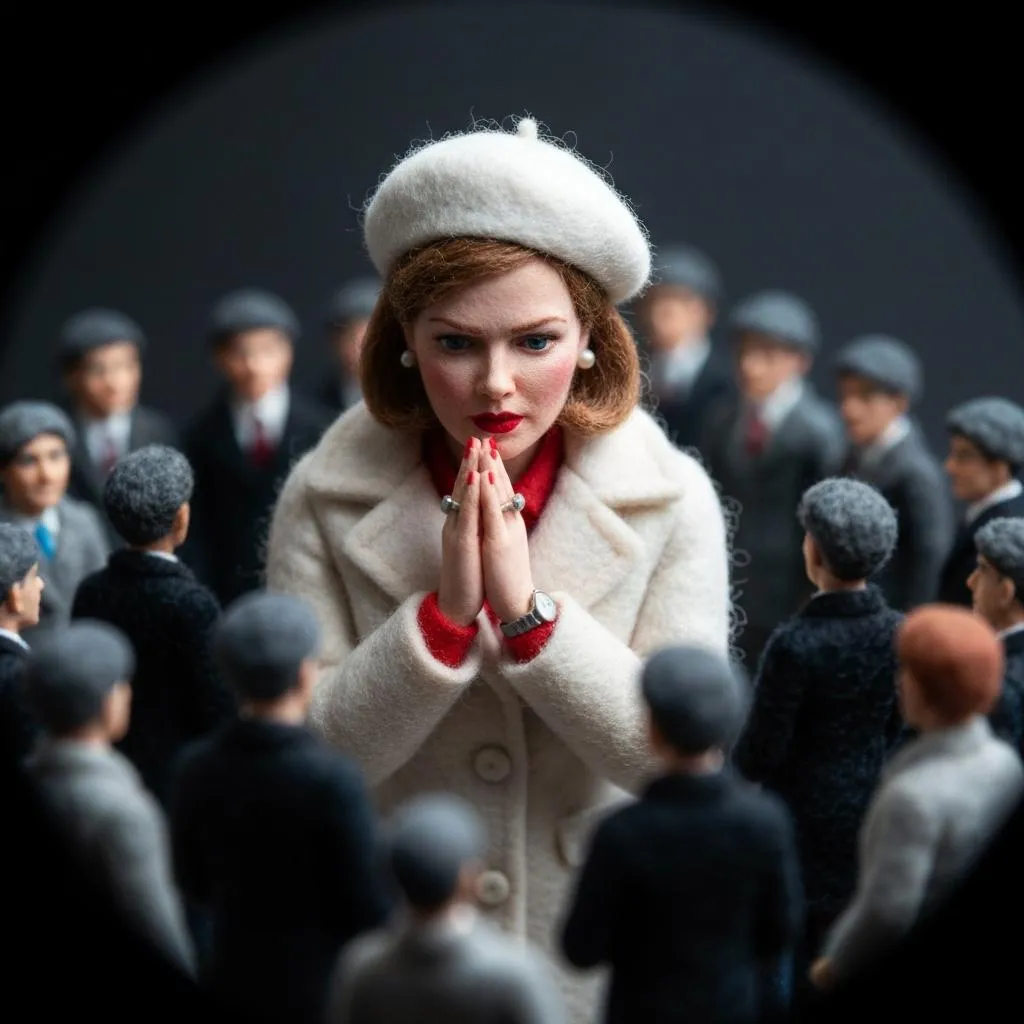

In [51]:
scene_view.select(
    scene_view.pos,
    scene_view.scene_prompt,
    scene_view.scene_image
).order_by(scene_view.title, scene_view.pos).collect()

Now that these are stored persistently, you can see the images have a spot in your local file cache. Read more about external files in our docs: https://docs.pixeltable.com/platform/external-files

scene_image,scene_image_localpath
,/Users/alison-pxt/.pixeltable/media/9e8b5aefbd5643d292fa9672fff695ad/bc/bce2/9e8b5aefbd5643d292fa9672fff695ad_61_72_bce2c32dd4d74ec4b23354464fb28898.jpeg

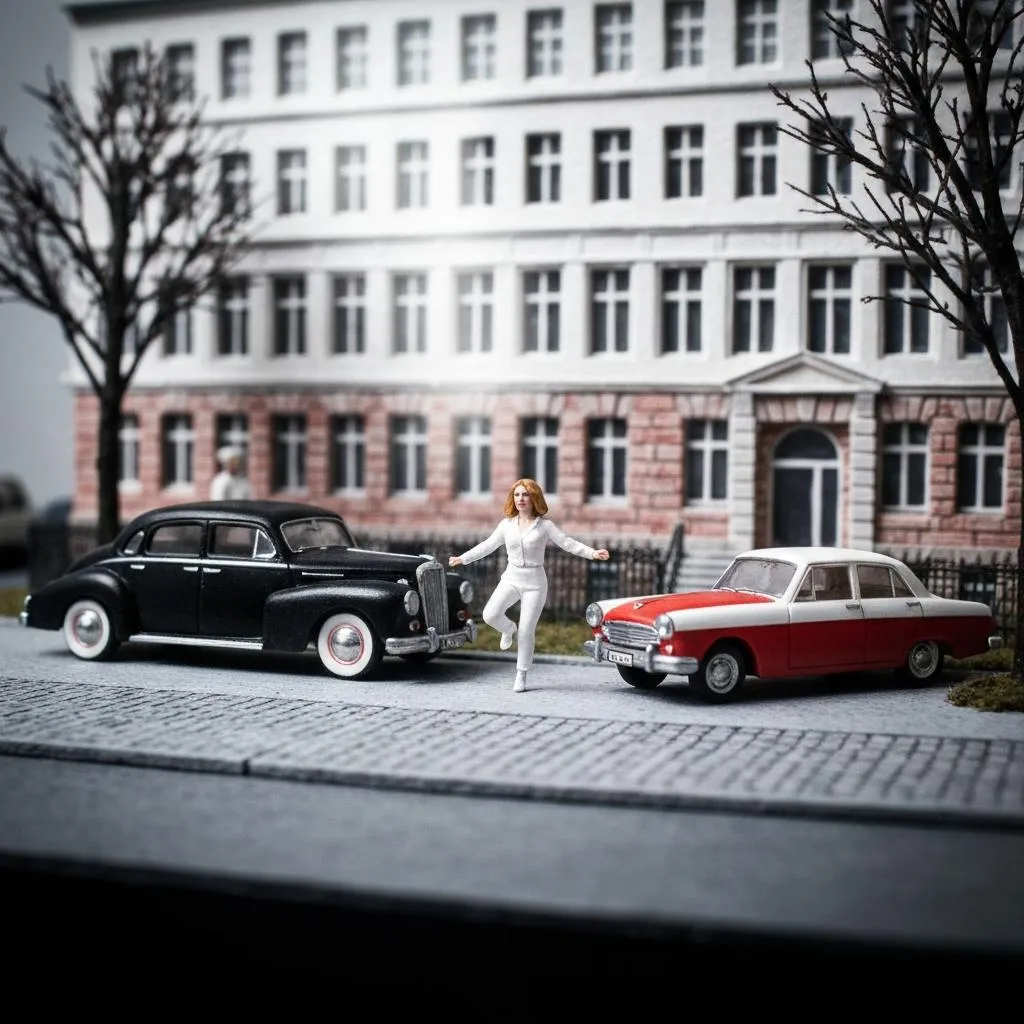

In [53]:
scene_view.select(
    scene_view.scene_image,
    scene_view.scene_image.localpath
).limit(1).collect()

If any rows encountered errors during processing (rate limits, API issues, etc.), you can recompute just those rows where Pixeltable logged errors:

In [54]:
# Recompute any rows that had errors
scene_view.recompute_columns(
    scene_view.scene_image,
    errors_only=True
)

1 row updated, 1 exception.

In [ ]:
scene_view.select(
    scene_view.pos,
    scene_view.scene_prompt,
    scene_view.scene_image
).order_by(scene_view.title, scene_view.pos).collect()

## 06 - (Optional) Video Generation

This section demonstrates two ways to use Gemini for video generation. Video generation is slower and more expensive than text or image generation. At the time of this workshop, the code we provide here should keep you safely in the free tier of four videos per day.

- **Image Input: Generate Videos from Image Only** - Slower, simpler approach (`veo-3.1-generate-preview`)
- **Multimodal Inputs: Generate Videos from Prompt + Image** - Slower, more tokens, production quality (`veo-3.1-generate-preview`)

### Image Input: Animate an Image (No Text Prompt)

This simpler approach animates the frame without a text prompt - just the image itself.

In [ ]:
scene_animation = scene_view.where(scene_view.pos == 7).select(
    scene_view.pos,
    scene_view.beginning_frame,
    animated_video=pxtf.gemini.generate_videos(
        image=scene_view.scene_image.resize((640, 360)),
        model='veo-3.1-generate-preview',
        config={'duration_seconds': 4}
    )
).collect()

In [ ]:
scene_animation

### Multimodal Inputs: Generate a Video from Prompt + Image

Test video generation using both the `scene_prompt` and the `scene_image`. Save the results of this query in memory as `scene_trailer`.

In [ ]:
scene_trailer = scene_view.where(scene_view.pos == 7).select(
    scene_view.pos,
    scene_view.scene_prompt,
    trailer_video=pxtf.gemini.generate_videos(
        prompt=scene_view.scene_prompt,
        image=scene_view.scene_image.resize((640, 360)),
        model='veo-3.1-generate-preview',
        config={'duration_seconds': 4}
    )
).collect()

In [ ]:
scene_trailer

## Wrap-Up

**Across this three-part workshop, you built a complete multimodal AI pipeline:**

- **Act 1**: Visual search - Extract frames, create embeddings, search by image or text
- **Act 2**: Audio search - Detect scenes, transcribe audio, search by semantic meaning
- **Act 3**: Content generation - Chain AI models to create new images and videos

In Act 3, you built a content generation pipeline that chains AI models together using computed columns:

```
┌────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  INPUT                EXTRACT              ANALYZE                GENERATE                                  │
│                                                                                                             │
│  ┌──────────────┐   ┌────────────────┐   ┌──────────────────┐   ┌──────────────────────────────────────┐  │
│  │   Scenes     │──▶│     Frame      │──▶│  Multimodal AI   │──▶│          Generation                  │  │
│  │              │   │   Extraction   │   │                  │   │                                      │  │
│  │ Video scenes │   │                │   │ Input:           │   │  ┌────────────┐   ┌──────────────┐  │  │
│  │ with         │   │ Input:         │   │ • image (frame)  │   │  │   Imagen   │──▶│     Veo      │  │  │
│  │ metadata:    │   │ • video        │   │ • text (title)   │   │  │    4.0     │   │     3.1      │  │  │
│  │ • video      │   │                │   │ • text (promo)   │   │  │            │   │              │  │  │
│  │ • title      │   │ Output:        │   │ • text (script)  │   │  │ Input:     │   │ Input:       │  │  │
│  │ • promo      │   │ • image        │   │                  │   │  │ • text     │   │ • image      │  │  │
│  │ • transcript │   │                │   │ Model:           │   │  │   (prompt) │   │ • text       │  │  │
│  │              │   │                │   │ Gemini 2.0 Flash │   │  │            │   │   (prompt)   │  │  │
│  │              │   │                │   │                  │   │  │ Output:    │   │              │  │  │
│  │              │   │                │   │ Output:          │   │  │ • image    │   │ Output:      │  │  │
│  │              │   │                │   │ • text (prompt)  │   │  └────────────┘   │ • video      │  │  │
│  │              │   │                │   │                  │   │                   └──────────────┘  │  │
│  └──────────────┘   └────────────────┘   └──────────────────┘   └──────────────────────────────────────┘  │
└────────────────────────────────────────────────────────────────────────────────────────────────────────────┘
```

**What you built:**

You added content generation to your video pipeline. Act 1 gave you visual similarity search (find frames by what they look like). Act 2 gave you semantic audio search (find scenes by what's being said). Act 3 gives you generative AI (create new promotional content from any scene).

Together, these three capabilities form a complete multimodal system. The embeddings from Act 1 power visual search. The scene detection and transcription from Act 2 structure the video data and make it searchable by audio. Act 3 chains multiple AI models—Gemini analyzes frames and transcripts to write prompts, Imagen generates images from those prompts, and Veo can animate them into video clips.

**Each step is declarative:**
- **Input**: Scene data from `scene_view` (built in Act 2)
- **Extract**: Frame extraction via computed column processes all scenes
- **Generate**: AI models chain together via computed columns—Gemini's output becomes Imagen's input
- **Cascade**: When you add new videos to `primetime_vids`, the scene detection, transcription, and generation pipeline processes them

The workflow applies to all data. If you load another video tomorrow, the same pipeline that processed your first video will process the new one.

Now let's generate images for all scenes using our `scene_prompt` column:

In [ ]:
scene_view.add_computed_column(
    scene_image=pxtf.gemini.generate_images(
        prompt=scene_view.scene_prompt,
        model='imagen-4.0-generate-001'
    ),
    if_exists='replace',
    on_error='ignore'
)

You can also generate a video-specific prompt by passing `content_type='video'` to include claymation-style instructions:

In [ ]:
scene_video_claymation = scene_view.where(scene_view.pos == 7).select(
    scene_view.pos,
    # Generate a video-specific prompt with claymation instructions
    video_prompt=build_scene_prompt(
        scene_view.title,
        scene_view.promo_text,
        scene_view.transcript_text,
        content_type='video'
    ),
    # Use the video prompt with Gemini
    scene_video=extract_text(
        pxtf.gemini.generate_content(
            contents=[
                build_scene_prompt(
                    scene_view.title,
                    scene_view.promo_text,
                    scene_view.transcript_text,
                    content_type='video'
                ),
                scene_view.beginning_frame
            ],
            model='gemini-2.0-flash-exp'
        )
    )
).collect()

View the generated images alongside the prompts:

In [ ]:
scene_view.select(
    scene_view.pos,
    scene_view.scene_prompt,
    scene_view.scene_image
).order_by(scene_view.title, scene_view.pos).collect()